In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt


# @title REALDSIP Data Preprocessing and Extraction

In [ ]:
!wget https://archive.ics.uci.edu/static/public/305/realdisp+activity+recognition+dataset.zip  -O dataset.zip

--2024-12-08 20:52:15--  https://archive.ics.uci.edu/static/public/305/realdisp+activity+recognition+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘dataset.zip’

dataset.zip             [       <=>          ]   2.49G  19.1MB/s    in 98s     

2024-12-08 20:53:53 (26.1 MB/s) - ‘dataset.zip’ saved [2671716334]



In [ ]:
import zipfile
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')

# Set path to the dataset folder
dataset_path = './dataset'


Now we define specify columns for accelerometer data and activity labels in the REALDISP dataset.

The resample_data funtion resamples data to 30hz.

The load_realdisp_data function loads .log files using pandas, extracting sensor data (left lower arm accelerometer) and corresponding activity labels.

The prepare_data_for_model function processes multiple files (ideal and self-placement), stacking the extracted data into arrays for model input.

Finally, the create_windows function generates sliding windows of data with overlap, preparing features and labels for time-series modeling.

These steps ensure proper preprocessing and formatting of data for downstream tasks like training or evaluation.

In [ ]:
# @title REALDSIP Data Preprocessing and Extraction
# Define columns of interest based on the manual
import warnings


# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Define columns of interest based on the manual
LLA_ACC_X = 55
LLA_ACC_Y = 56
LLA_ACC_Z = 57
ACTIVITY_LABEL = -1  # Last column is activity label

def resample_data(data, labels, original_freq=50, target_freq=30):
    """
    Resample the data from the original frequency to the target frequency.

    Args:
        data (ndarray): Sensor data with shape (n_samples, n_features).
        labels (ndarray): Corresponding labels with shape (n_samples,).
        original_freq (int): Original sampling frequency of the data.
        target_freq (int): Target sampling frequency.

    Returns:
        resampled_data (ndarray): Resampled sensor data.
        resampled_labels (ndarray): Resampled labels.
    """
    factor = original_freq / target_freq
    if not factor.is_integer():
        raise ValueError("Original frequency must be a multiple of the target frequency.")

    factor = int(factor)
    resampled_data = data[::factor]
    resampled_labels = labels[::factor]
    return resampled_data, resampled_labels

def load_realdisp_data(file_path, sensor_columns, resample=False, target_freq=30):
    """
    Load data from a REALDISP .log file and extract relevant sensor columns and activity labels.

    Args:
        file_path (str): Path to the log file.
        sensor_columns (list): Columns to extract for sensor data.
        resample (bool): Whether to resample the data to a lower frequency.
        target_freq (int): Target frequency for resampling.

    Returns:
        lla_data (ndarray): Sensor data.
        labels (ndarray): Corresponding activity labels.
    """
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    lla_data = df.iloc[:, sensor_columns].values
    labels = df.iloc[:, ACTIVITY_LABEL].values

    if resample:
        lla_data, labels = resample_data(lla_data, labels, original_freq=50, target_freq=target_freq)

    return lla_data, labels

def create_windows(X, y, window_size=300, overlap=0.5):
    """
    Create sliding windows from the data with overlap.
    """
    step = int(window_size * (1 - overlap))
    features, labels = [], []

    for i in range(0, len(X) - window_size, step):
        window = X[i:i + window_size].T  # Shape as (channels, sequence_length)
        if window.shape == (3, window_size):
            label = y[i + window_size // 2]  # Take the middle label
            features.append(window)
            labels.append(label)

    return np.array(features), np.array(labels)

def prepare_data_for_model(ideal_files, self_files, resample=False, target_freq=30):
    """
    Load and prepare the dataset with windowing for both ideal and self-placement files.

    Args:
        ideal_files (list): List of ideal placement files.
        self_files (list): List of self-placement files.
        resample (bool): Whether to resample the data to a lower frequency.
        target_freq (int): Target frequency for resampling.

    Returns:
        X_ideal, y_ideal, X_self, y_self: Processed data and labels.
    """
    X_ideal, y_ideal = [], []
    X_self, y_self = [], []

    for file in ideal_files:
        lla_data, labels = load_realdisp_data(
            os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z],
            resample=resample, target_freq=target_freq
        )
        X_windows, y_windows = create_windows(lla_data, labels)
        X_ideal.extend(X_windows)
        y_ideal.extend(y_windows)

    for file in self_files:
        lla_data, labels = load_realdisp_data(
            os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z],
            resample=resample, target_freq=target_freq
        )
        X_windows, y_windows = create_windows(lla_data, labels)
        X_self.extend(X_windows)
        y_self.extend(y_windows)

    return np.array(X_ideal), np.array(y_ideal), np.array(X_self), np.array(y_self)

def extract_features(window):
    """
    Extracts statistical features from a single window of data.
    """
    features = []
    for axis in range(window.shape[0]):
        axis_data = window[axis, :]
        features.extend([
            np.max(axis_data), np.min(axis_data), np.sum(axis_data),
            np.mean(axis_data), np.median(axis_data), np.std(axis_data),
            np.abs(axis_data).mean(), skew(axis_data), kurtosis(axis_data)
        ])
    return np.array(features)

def prepare_feature_data(X_windows):
    """
    Applies feature extraction on each window of data and returns a feature matrix.
    """
    feature_matrix = [extract_features(window) for window in X_windows]
    return np.array(feature_matrix)


Now we implement a leave-one-participant-out (LOPO) cross-validation approach, where participant 17 is excluded from the training set and used exclusively for testing.

In [ ]:
# Define the participant to leave out
participant_id = '17'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print("Training Ideal Files:", len(ideal_files))
print("Training Self Files:", len(self_files))
print("Testing Ideal Files (Participant 17):", len(ideal_test_files))
print("Testing Self Files (Participant 17):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)



Training Ideal Files: 16
Training Self Files: 16
Testing Ideal Files (Participant 17): 1
Testing Self Files (Participant 17): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Now, we’ll apply the extract_features function to each window in X_ideal_train, X_self_train, X_ideal_test, and X_self_test. Each window will be transformed into a feature vector, and all feature vectors will be combined into a dataset for training and testing.

In [ ]:
# Feature extraction
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Check shapes
print("Training Ideal Features Shape:", X_ideal_train_features.shape)
print("Training Self Features Shape:", X_self_train_features.shape)
print("Testing Ideal Features Shape:", X_ideal_test_features.shape)
print("Testing Self Features Shape:", X_self_test_features.shape)

Training Ideal Features Shape: (16528, 27)
Training Self Features Shape: (18318, 27)
Testing Ideal Features Shape: (648, 27)
Testing Self Features Shape: (1048, 27)


Windowing and feature extraction is applied to each window. This way, the features for Random Forest are based on the statistical properties of each window.
Print statements are used to confirm that features are in correct shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Combine the training features and labels
X_train_combined = np.vstack((X_ideal_train_features, X_self_train_features))
y_train_combined = np.hstack((y_ideal_train, y_self_train))

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Predictions and classification report on ideal test data (participant 17)
y_ideal_pred = rf_model.predict(X_ideal_test_features)
print("Classification Report for Ideal Test Data (Participant 17):")
print(classification_report(y_ideal_test, y_ideal_pred))

# Predictions and classification report on self-placement test data (participant 17)
y_self_pred = rf_model.predict(X_self_test_features)
print("Classification Report for Self-Placement Test Data (Participant 17):")
print(classification_report(y_self_test, y_self_pred))


Classification Report for Ideal Test Data (Participant 17):
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       366
           1       0.60      0.14      0.22        22
           2       0.55      1.00      0.71        21
           3       0.89      0.38      0.53        21
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.80      0.57      0.67         7
           7       0.00      0.00      0.00         7
           8       1.00      0.75      0.86         4
           9       0.56      0.38      0.45        13
          10       1.00      1.00      1.00        10
          11       1.00      0.17      0.29        12
          12       0.00      0.00      0.00         7
          13       0.71      0.83      0.77        12
          14       1.00      0.56      0.71         9
          15       0.33      0.25      0.29         8
          16       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       878
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.25      0.40         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7
           7       1.00      0.71      0.83         7
           8       1.00      1.00      1.00         4
           9       0.33      0.23      0.27        13
          10       1.00      1.00      1.00        11
          11       1.00      0.17      0.29        12
          12       1.00      0.43      0.60         7
          13       0.82      0.82      0.82        11
          14       1.00      0.44      0.62         9
          15       0.57      0.50      0.53         8
          16       0.00      0.00      0.00         8
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
#@title Participant left out = 17
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the participant to leave out
participant_id = '17'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 17): 16
Training Self Files (Excluding Participant 17): 16
Testing Ideal Files (Participant 17): 1
Testing Self Files (Participant 17): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train (Excluding Participant 17): (16528, 3, 300)
Shape of y_ideal_train (Excluding Participant 17): (16528,)
Shape of X_self_train (Excluding Participant 17): (18318, 3, 300)
Shape of y_self_train (Excluding Participant 17): (18318,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 17): (648, 3, 300)
Shape of y_ideal_test (Participant 17): (648,)
Shape of X_self_test (Participant 17): (1048, 3, 300)
Shape of y_self_test (Participant 17): (1048,)
Training Ideal Features Shape (Excluding Participant 17): (16528, 27)
Training Self Features Shape (Excluding Participant 17): (18318, 27)
Testing Ideal Features Shape (Participant 17): (648, 27)
Testing Self Features Shape (Participant 17): (1048, 27)
Combined Training Features Shape (Excluding Participant 17): (34846, 27)
Combined Training Labels Shape (Excluding Participant 17): (34846,)

Classification Report for Ideal Test Data (Participant 17):
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       366
           1       0.60      0.14      0.22        22
           2       0.55      1.00      0.71        21
           3       0.89      0.38      0.53        21
           4       0.00      0.00      0.00         4
           5      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 16
participant_id = '16'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print("Training Ideal Files:", len(ideal_files))
print("Training Self Files:", len(self_files))
print("Testing Ideal Files (Participant 16):", len(ideal_test_files))
print("Testing Self Files (Participant 16):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print("Shape of X_ideal_train:", X_ideal_train.shape)
print("Shape of y_ideal_train:", y_ideal_train.shape)
print("Shape of X_self_train:", X_self_train.shape)
print("Shape of y_self_train:", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print("Shape of X_ideal_test:", X_ideal_test.shape)
print("Shape of y_ideal_test:", y_ideal_test.shape)
print("Shape of X_self_test:", X_self_test.shape)
print("Shape of y_self_test:", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print("Training Ideal Features Shape:", X_ideal_train_features.shape)
print("Training Self Features Shape:", X_self_train_features.shape)
print("Testing Ideal Features Shape:", X_ideal_test_features.shape)
print("Testing Self Features Shape:", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print("Combined Training Features Shape:", X_train_combined.shape)
print("Combined Training Labels Shape:", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data (Participant 16)
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print("\nClassification Report for Ideal Test Data (Participant 16):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data (Participant 16)
y_pred_self = rf_model.predict(X_self_test_features)
print("\nClassification Report for Self-Placement Test Data (Participant 16):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files: 16
Training Self Files: 16
Testing Ideal Files (Participant 16): 1
Testing Self Files (Participant 16): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train: (16545, 3, 300)
Shape of y_ideal_train: (16545,)
Shape of X_self_train: (18262, 3, 300)
Shape of y_self_train: (18262,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test: (631, 3, 300)
Shape of y_ideal_test: (631,)
Shape of X_self_test: (1104, 3, 300)
Shape of y_self_test: (1104,)
Training Ideal Features Shape: (16545, 27)
Training Self Features Shape: (18262, 27)
Testing Ideal Features Shape: (631, 27)
Testing Self Features Shape: (1104, 27)
Combined Training Features Shape: (34807, 27)
Combined Training Labels Shape: (34807,)

Classification Report for Ideal Test Data (Participant 16):
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       337
           1       1.00      0.06      0.11        18
           2       0.31      0.61      0.42        18
           3       0.56      0.26      0.36        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         6
           9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 15

# Define the participant to leave out
participant_id = '15'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 15): 16
Training Self Files (Excluding Participant 15): 16
Testing Ideal Files (Participant 15): 1
Testing Self Files (Participant 15): 1
Testing Ideal File Name(s) for Participant 15: ['subject15_ideal.log']
Testing Self File Name(s) for Participant 15: ['subject15_self.log']
Shape of X_ideal_train (Excluding Participant 15): (15966, 3, 300)
Shape of y_ideal_train (Excluding Participant 15): (15966,)
Shape of X_self_train (Excluding Participant 15): (18179, 3, 300)
Shape of y_self_train (Excluding Participant 15): (18179,)
Shape of X_ideal_test (Participant 15): (1210, 3, 300)
Shape of y_ideal_test (Participant 15): (1210,)
Shape of X_self_test (Participant 15): (1187, 3, 300)
Shape of y_self_test (Participant 15): (1187,)
Training Ideal Features Shape (Excluding Participant 15): (15966, 27)
Training Self Features Shape (Excluding Participant 15): (18179, 27)
Testing Ideal Features Shape (Participant 15): (1210, 27)
Testing Self Features Sha

In [ ]:
#@title Participant left out = 14

# Define the participant to leave out
participant_id = '14'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 14): 16
Training Self Files (Excluding Participant 14): 16
Testing Ideal Files (Participant 14): 1
Testing Self Files (Participant 14): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train (Excluding Participant 14): (15687, 3, 300)
Shape of y_ideal_train (Excluding Participant 14): (15687,)
Shape of X_self_train (Excluding Participant 14): (18169, 3, 300)
Shape of y_self_train (Excluding Participant 14): (18169,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 14): (1489, 3, 300)
Shape of y_ideal_test (Participant 14): (1489,)
Shape of X_self_test (Participant 14): (1197, 3, 300)
Shape of y_self_test (Participant 14): (1197,)
Training Ideal Features Shape (Excluding Participant 14): (15687, 27)
Training Self Features Shape (Excluding Participant 14): (18169, 27)
Testing Ideal Features Shape (Participant 14): (1489, 27)
Testing Self Features Shape (Participant 14): (1197, 27)
Combined Training Features Shape (Excluding Participant 14): (33856, 27)
Combined Training Labels Shape (Excluding Participant 14): (33856,)

Classification Report for Ideal Test Data (Participant 14):
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      1186
           1       0.86      0.30      0.44        20
           2       0.25      0.06      0.09        18
           3       0.48      0.94      0.64        17
           4       0.00      0.00      0.00         3
           5   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 13

# Define the participant to leave out
participant_id = '13'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 13): 16
Training Self Files (Excluding Participant 13): 16
Testing Ideal Files (Participant 13): 1
Testing Self Files (Participant 13): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train (Excluding Participant 13): (15846, 3, 300)
Shape of y_ideal_train (Excluding Participant 13): (15846,)
Shape of X_self_train (Excluding Participant 13): (18433, 3, 300)
Shape of y_self_train (Excluding Participant 13): (18433,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 13): (1330, 3, 300)
Shape of y_ideal_test (Participant 13): (1330,)
Shape of X_self_test (Participant 13): (933, 3, 300)
Shape of y_self_test (Participant 13): (933,)
Training Ideal Features Shape (Excluding Participant 13): (15846, 27)
Training Self Features Shape (Excluding Participant 13): (18433, 27)
Testing Ideal Features Shape (Participant 13): (1330, 27)
Testing Self Features Shape (Participant 13): (933, 27)
Combined Training Features Shape (Excluding Participant 13): (34279, 27)
Combined Training Labels Shape (Excluding Participant 13): (34279,)

Classification Report for Ideal Test Data (Participant 13):
              precision    recall  f1-score   support

           0       0.84      0.99      0.90       953
           1       0.56      0.52      0.54        29
           2       0.76      0.97      0.85        33
           3       1.00      0.33      0.50        21
           4       0.00      0.00      0.00         4
           5      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 12

# Define the participant to leave out
participant_id = '12'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 12): 16
Training Self Files (Excluding Participant 12): 16
Testing Ideal Files (Participant 12): 1
Testing Self Files (Participant 12): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train (Excluding Participant 12): (16239, 3, 300)
Shape of y_ideal_train (Excluding Participant 12): (16239,)
Shape of X_self_train (Excluding Participant 12): (18396, 3, 300)
Shape of y_self_train (Excluding Participant 12): (18396,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 12): (937, 3, 300)
Shape of y_ideal_test (Participant 12): (937,)
Shape of X_self_test (Participant 12): (970, 3, 300)
Shape of y_self_test (Participant 12): (970,)
Training Ideal Features Shape (Excluding Participant 12): (16239, 27)
Training Self Features Shape (Excluding Participant 12): (18396, 27)
Testing Ideal Features Shape (Participant 12): (937, 27)
Testing Self Features Shape (Participant 12): (970, 27)
Combined Training Features Shape (Excluding Participant 12): (34635, 27)
Combined Training Labels Shape (Excluding Participant 12): (34635,)

Classification Report for Ideal Test Data (Participant 12):
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       591
           1       0.00      0.00      0.00        34
           2       0.89      0.35      0.50        23
           3       0.33      1.00      0.50        15
           4       0.00      0.00      0.00         4
           5       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
#@title Participant left out = 11

# Define the participant to leave out
participant_id = '11'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 11): 16
Training Self Files (Excluding Participant 11): 16
Testing Ideal Files (Participant 11): 1
Testing Self Files (Participant 11): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train (Excluding Participant 11): (16245, 3, 300)
Shape of y_ideal_train (Excluding Participant 11): (16245,)
Shape of X_self_train (Excluding Participant 11): (18320, 3, 300)
Shape of y_self_train (Excluding Participant 11): (18320,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 11): (931, 3, 300)
Shape of y_ideal_test (Participant 11): (931,)
Shape of X_self_test (Participant 11): (1046, 3, 300)
Shape of y_self_test (Participant 11): (1046,)
Training Ideal Features Shape (Excluding Participant 11): (16245, 27)
Training Self Features Shape (Excluding Participant 11): (18320, 27)
Testing Ideal Features Shape (Participant 11): (931, 27)
Testing Self Features Shape (Participant 11): (1046, 27)
Combined Training Features Shape (Excluding Participant 11): (34565, 27)
Combined Training Labels Shape (Excluding Participant 11): (34565,)

Classification Report for Ideal Test Data (Participant 11):
              precision    recall  f1-score   support

           0       0.78      0.98      0.86       591
           1       0.00      0.00      0.00        34
           2       0.89      0.70      0.78        23
           3       1.00      0.27      0.42        15
           4       0.00      0.00      0.00         4
           5      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 10

# Define the participant to leave out
participant_id = '10'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 10): 16
Training Self Files (Excluding Participant 10): 16
Testing Ideal Files (Participant 10): 1
Testing Self Files (Participant 10): 1
Shape of X_ideal_train (Excluding Participant 10): (15788, 3, 300)
Shape of y_ideal_train (Excluding Participant 10): (15788,)
Shape of X_self_train (Excluding Participant 10): (17958, 3, 300)
Shape of y_self_train (Excluding Participant 10): (17958,)
Shape of X_ideal_test (Participant 10): (1388, 3, 300)
Shape of y_ideal_test (Participant 10): (1388,)
Shape of X_self_test (Participant 10): (1408, 3, 300)
Shape of y_self_test (Participant 10): (1408,)
Training Ideal Features Shape (Excluding Participant 10): (15788, 27)
Training Self Features Shape (Excluding Participant 10): (17958, 27)
Testing Ideal Features Shape (Participant 10): (1388, 27)
Testing Self Features Shape (Participant 10): (1408, 27)
Combined Training Features Shape (Excluding Participant 10): (33746, 27)
Combined Training Labels Shape (Exc

In [ ]:
#@title Participant left out = 9

# Define the participant to leave out
participant_id = '9'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 9): 16
Training Self Files (Excluding Participant 9): 16
Testing Ideal Files (Participant 9): 1
Testing Self Files (Participant 9): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train (Excluding Participant 9): (15808, 3, 300)
Shape of y_ideal_train (Excluding Participant 9): (15808,)
Shape of X_self_train (Excluding Participant 9): (18023, 3, 300)
Shape of y_self_train (Excluding Participant 9): (18023,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 9): (1368, 3, 300)
Shape of y_ideal_test (Participant 9): (1368,)
Shape of X_self_test (Participant 9): (1343, 3, 300)
Shape of y_self_test (Participant 9): (1343,)
Training Ideal Features Shape (Excluding Participant 9): (15808, 27)
Training Self Features Shape (Excluding Participant 9): (18023, 27)
Testing Ideal Features Shape (Participant 9): (1368, 27)
Testing Self Features Shape (Participant 9): (1343, 27)
Combined Training Features Shape (Excluding Participant 9): (33831, 27)
Combined Training Labels Shape (Excluding Participant 9): (33831,)

Classification Report for Ideal Test Data (Participant 9):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1051
           1       0.00      0.00      0.00        27
           2       0.38      0.94      0.54        16
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         4
           5       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 8

# Define the participant to leave out
participant_id = '8'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 8): 16
Training Self Files (Excluding Participant 8): 16
Testing Ideal Files (Participant 8): 1
Testing Self Files (Participant 8): 1


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddc

Shape of X_ideal_train (Excluding Participant 8): (16183, 3, 300)
Shape of y_ideal_train (Excluding Participant 8): (16183,)
Shape of X_self_train (Excluding Participant 8): (18007, 3, 300)
Shape of y_self_train (Excluding Participant 8): (18007,)


<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-20-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 8): (993, 3, 300)
Shape of y_ideal_test (Participant 8): (993,)
Shape of X_self_test (Participant 8): (1359, 3, 300)
Shape of y_self_test (Participant 8): (1359,)
Training Ideal Features Shape (Excluding Participant 8): (16183, 27)
Training Self Features Shape (Excluding Participant 8): (18007, 27)
Testing Ideal Features Shape (Participant 8): (993, 27)
Testing Self Features Shape (Participant 8): (1359, 27)
Combined Training Features Shape (Excluding Participant 8): (34190, 27)
Combined Training Labels Shape (Excluding Participant 8): (34190,)

Classification Report for Ideal Test Data (Participant 8):
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       713
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        16
           3       0.50      1.00      0.67        17
           4       0.00      0.00      0.00         4
           5       0.50      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 7

# Define the participant to leave out
participant_id = '7'

# Separate files for training and testing
# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 7): 16
Training Self Files (Excluding Participant 7): 16
Testing Ideal Files (Participant 7): 1
Testing Self Files (Participant 7): 1
Testing Ideal File Name(s) for Participant 7: ['subject7_ideal.log']
Testing Self File Name(s) for Participant 7: ['subject7_self.log']


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9

Shape of X_ideal_train (Excluding Participant 7): (16545, 3, 300)
Shape of y_ideal_train (Excluding Participant 7): (16545,)
Shape of X_self_train (Excluding Participant 7): (18283, 3, 300)
Shape of y_self_train (Excluding Participant 7): (18283,)


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 7): (631, 3, 300)
Shape of y_ideal_test (Participant 7): (631,)
Shape of X_self_test (Participant 7): (1083, 3, 300)
Shape of y_self_test (Participant 7): (1083,)
Training Ideal Features Shape (Excluding Participant 7): (16545, 27)
Training Self Features Shape (Excluding Participant 7): (18283, 27)
Testing Ideal Features Shape (Participant 7): (631, 27)
Testing Self Features Shape (Participant 7): (1083, 27)
Combined Training Features Shape (Excluding Participant 7): (34828, 27)
Combined Training Labels Shape (Excluding Participant 7): (34828,)

Classification Report for Ideal Test Data (Participant 7):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       591
           1       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          30       1.00      0.14      0.25         7
          31       0.50      0.07      0.12        14
          32       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
#@title Participant left out = 6

# Define the participant to leave out
participant_id = '6'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 6): 16
Training Self Files (Excluding Participant 6): 16
Testing Ideal Files (Participant 6): 1
Testing Self Files (Participant 6): 1
Testing Ideal File Name(s) for Participant 6: ['subject6_ideal.log']
Testing Self File Name(s) for Participant 6: ['subject6_self.log']


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9

Shape of X_ideal_train (Excluding Participant 6): (16506, 3, 300)
Shape of y_ideal_train (Excluding Participant 6): (16506,)
Shape of X_self_train (Excluding Participant 6): (18355, 3, 300)
Shape of y_self_train (Excluding Participant 6): (18355,)


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 6): (670, 3, 300)
Shape of y_ideal_test (Participant 6): (670,)
Shape of X_self_test (Participant 6): (1011, 3, 300)
Shape of y_self_test (Participant 6): (1011,)
Training Ideal Features Shape (Excluding Participant 6): (16506, 27)
Training Self Features Shape (Excluding Participant 6): (18355, 27)
Testing Ideal Features Shape (Participant 6): (670, 27)
Testing Self Features Shape (Participant 6): (1011, 27)
Combined Training Features Shape (Excluding Participant 6): (34861, 27)
Combined Training Labels Shape (Excluding Participant 6): (34861,)

Classification Report for Ideal Test Data (Participant 6):
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       476
           1       0.83      0.48      0.61        21
           2       0.45      0.87      0.59        15
           3       0.67      0.20      0.31        20
           4       0.00      0.00      0.00         3
           5       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
#@title Participant left out = 5

# Define the participant to leave out
participant_id = '5'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 5): 16
Training Self Files (Excluding Participant 5): 16
Testing Ideal Files (Participant 5): 1
Testing Self Files (Participant 5): 1
Testing Ideal File Name(s) for Participant 5: ['subject5_ideal.log']
Testing Self File Name(s) for Participant 5: ['subject5_self.log']


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9

Shape of X_ideal_train (Excluding Participant 5): (15697, 3, 300)
Shape of y_ideal_train (Excluding Participant 5): (15697,)
Shape of X_self_train (Excluding Participant 5): (18335, 3, 300)
Shape of y_self_train (Excluding Participant 5): (18335,)


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 5): (1479, 3, 300)
Shape of y_ideal_test (Participant 5): (1479,)
Shape of X_self_test (Participant 5): (1031, 3, 300)
Shape of y_self_test (Participant 5): (1031,)
Training Ideal Features Shape (Excluding Participant 5): (15697, 27)
Training Self Features Shape (Excluding Participant 5): (18335, 27)
Testing Ideal Features Shape (Participant 5): (1479, 27)
Testing Self Features Shape (Participant 5): (1031, 27)
Combined Training Features Shape (Excluding Participant 5): (34032, 27)
Combined Training Labels Shape (Excluding Participant 5): (34032,)

Classification Report for Ideal Test Data (Participant 5):
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1173
           1       0.79      0.52      0.63        21
           2       1.00      0.27      0.42        15
           3       1.00      0.90      0.95        20
           4       0.00      0.00      0.00         4
           5       1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 4

# Define the participant to leave out
participant_id = '4'

# Separate files for training and testing
# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 4): 16
Training Self Files (Excluding Participant 4): 16
Testing Ideal Files (Participant 4): 1
Testing Self Files (Participant 4): 1
Testing Ideal File Name(s) for Participant 4: ['subject4_ideal.log']
Testing Self File Name(s) for Participant 4: ['subject4_self.log']


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9

Shape of X_ideal_train (Excluding Participant 4): (16683, 3, 300)
Shape of y_ideal_train (Excluding Participant 4): (16683,)
Shape of X_self_train (Excluding Participant 4): (18033, 3, 300)
Shape of y_self_train (Excluding Participant 4): (18033,)


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 4): (493, 3, 300)
Shape of y_ideal_test (Participant 4): (493,)
Shape of X_self_test (Participant 4): (1333, 3, 300)
Shape of y_self_test (Participant 4): (1333,)
Training Ideal Features Shape (Excluding Participant 4): (16683, 27)
Training Self Features Shape (Excluding Participant 4): (18033, 27)
Testing Ideal Features Shape (Participant 4): (493, 27)
Testing Self Features Shape (Participant 4): (1333, 27)
Combined Training Features Shape (Excluding Participant 4): (34716, 27)
Combined Training Labels Shape (Excluding Participant 4): (34716,)

Classification Report for Ideal Test Data (Participant 4):
              precision    recall  f1-score   support

           0       0.72      0.97      0.83       262
           1       0.40      0.11      0.17        18
           2       1.00      0.74      0.85        19
           3       0.73      1.00      0.84        16
           4       0.00      0.00      0.00         3
           5       0.50      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
#@title Participant left out = 3

# Define the participant to leave out
participant_id = '3'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 3): 16
Training Self Files (Excluding Participant 3): 16
Testing Ideal Files (Participant 3): 1
Testing Self Files (Participant 3): 1
Testing Ideal File Name(s) for Participant 3: ['subject3_ideal.log']
Testing Self File Name(s) for Participant 3: ['subject3_self.log']


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9

Shape of X_ideal_train (Excluding Participant 3): (16601, 3, 300)
Shape of y_ideal_train (Excluding Participant 3): (16601,)
Shape of X_self_train (Excluding Participant 3): (18260, 3, 300)
Shape of y_self_train (Excluding Participant 3): (18260,)


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 3): (575, 3, 300)
Shape of y_ideal_test (Participant 3): (575,)
Shape of X_self_test (Participant 3): (1106, 3, 300)
Shape of y_self_test (Participant 3): (1106,)
Training Ideal Features Shape (Excluding Participant 3): (16601, 27)
Training Self Features Shape (Excluding Participant 3): (18260, 27)
Testing Ideal Features Shape (Participant 3): (575, 27)
Testing Self Features Shape (Participant 3): (1106, 27)
Combined Training Features Shape (Excluding Participant 3): (34861, 27)
Combined Training Labels Shape (Excluding Participant 3): (34861,)

Classification Report for Ideal Test Data (Participant 3):
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       306
           1       0.00      0.00      0.00        18
           2       1.00      0.67      0.80        18
           3       1.00      0.94      0.97        16
           4       0.00      0.00      0.00         4
           5       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 2

# Define the participant to leave out
participant_id = '2'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 2): 16
Training Self Files (Excluding Participant 2): 16
Testing Ideal Files (Participant 2): 1
Testing Self Files (Participant 2): 1
Testing Ideal File Name(s) for Participant 2: ['subject2_ideal.log']
Testing Self File Name(s) for Participant 2: ['subject2_self.log']


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9

Shape of X_ideal_train (Excluding Participant 2): (15965, 3, 300)
Shape of y_ideal_train (Excluding Participant 2): (15965,)
Shape of X_self_train (Excluding Participant 2): (18266, 3, 300)
Shape of y_self_train (Excluding Participant 2): (18266,)


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 2): (1211, 3, 300)
Shape of y_ideal_test (Participant 2): (1211,)
Shape of X_self_test (Participant 2): (1100, 3, 300)
Shape of y_self_test (Participant 2): (1100,)
Training Ideal Features Shape (Excluding Participant 2): (15965, 27)
Training Self Features Shape (Excluding Participant 2): (18266, 27)
Testing Ideal Features Shape (Participant 2): (1211, 27)
Testing Self Features Shape (Participant 2): (1100, 27)
Combined Training Features Shape (Excluding Participant 2): (34231, 27)
Combined Training Labels Shape (Excluding Participant 2): (34231,)

Classification Report for Ideal Test Data (Participant 2):
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       909
           1       0.80      0.17      0.29        23
           2       0.64      1.00      0.78        18
           3       1.00      0.56      0.71        18
           4       0.00      0.00      0.00         4
           5       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
#@title Participant left out = 1

# Define the participant to leave out
participant_id = '1'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Load and preprocess testing data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Extract features for training and testing
X_ideal_train_features = prepare_feature_data(X_ideal_train)
X_self_train_features = prepare_feature_data(X_self_train)
X_ideal_test_features = prepare_feature_data(X_ideal_test)
X_self_test_features = prepare_feature_data(X_self_test)

# Print the shapes of feature matrices
print(f"Training Ideal Features Shape (Excluding Participant {participant_id}):", X_ideal_train_features.shape)
print(f"Training Self Features Shape (Excluding Participant {participant_id}):", X_self_train_features.shape)
print(f"Testing Ideal Features Shape (Participant {participant_id}):", X_ideal_test_features.shape)
print(f"Testing Self Features Shape (Participant {participant_id}):", X_self_test_features.shape)

# Combine ideal and self-placement training data
X_train_combined = np.vstack([X_ideal_train_features, X_self_train_features])
y_train_combined = np.hstack([y_ideal_train, y_self_train])

# Print shapes after combining
print(f"Combined Training Features Shape (Excluding Participant {participant_id}):", X_train_combined.shape)
print(f"Combined Training Labels Shape (Excluding Participant {participant_id}):", y_train_combined.shape)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

# Evaluate on ideal test data
y_pred_ideal = rf_model.predict(X_ideal_test_features)
print(f"\nClassification Report for Ideal Test Data (Participant {participant_id}):")
print(classification_report(y_ideal_test, y_pred_ideal))

# Evaluate on self-placement test data
y_pred_self = rf_model.predict(X_self_test_features)
print(f"\nClassification Report for Self-Placement Test Data (Participant {participant_id}):")
print(classification_report(y_self_test, y_pred_self))


Training Ideal Files (Excluding Participant 1): 16
Training Self Files (Excluding Participant 1): 16
Testing Ideal Files (Participant 1): 1
Testing Self Files (Participant 1): 1
Testing Ideal File Name(s) for Participant 1: ['subject1_ideal.log']
Testing Self File Name(s) for Participant 1: ['subject1_self.log']


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9

Shape of X_ideal_train (Excluding Participant 1): (15984, 3, 300)
Shape of y_ideal_train (Excluding Participant 1): (15984,)
Shape of X_self_train (Excluding Participant 1): (18259, 3, 300)
Shape of y_self_train (Excluding Participant 1): (18259,)


<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-4-792ea6fddcfd>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 1): (1192, 3, 300)
Shape of y_ideal_test (Participant 1): (1192,)
Shape of X_self_test (Participant 1): (1107, 3, 300)
Shape of y_self_test (Participant 1): (1107,)
Training Ideal Features Shape (Excluding Participant 1): (15984, 27)
Training Self Features Shape (Excluding Participant 1): (18259, 27)
Testing Ideal Features Shape (Participant 1): (1192, 27)
Testing Self Features Shape (Participant 1): (1107, 27)
Combined Training Features Shape (Excluding Participant 1): (34243, 27)
Combined Training Labels Shape (Excluding Participant 1): (34243,)

Classification Report for Ideal Test Data (Participant 1):
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       883
           1       0.00      0.00      0.00        23
           2       0.58      0.78      0.67        18
           3       0.88      0.39      0.54        18
           4       1.00      0.50      0.67         4
           5       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

    Participant_id  Ideal_F1(SSL)  Self_F1(SSL)  Ideal_F1(RF)  Self_F1(RF)
0                1         0.9076        0.9134          0.84         0.82
1                2         0.9266        0.8986          0.87         0.85
2                3         0.8102        0.8703          0.72         0.81
3                4         0.8398        0.8427          0.75         0.81
4                5         0.9073        0.6719          0.89         0.68
5                6         0.9086        0.5704          0.82         0.70
6                7         0.9575        0.9116          0.92         0.83
7                8         0.8898        0.9200          0.84         0.87
8                9         0.9140        0.8930          0.88         0.87
9               10         0.9399        0.8964          0.88         0.89
10              11         0.8106        0.8660          0.77         0.81
11              12         0.8406        0.8395          0.78         0.80
12              13       

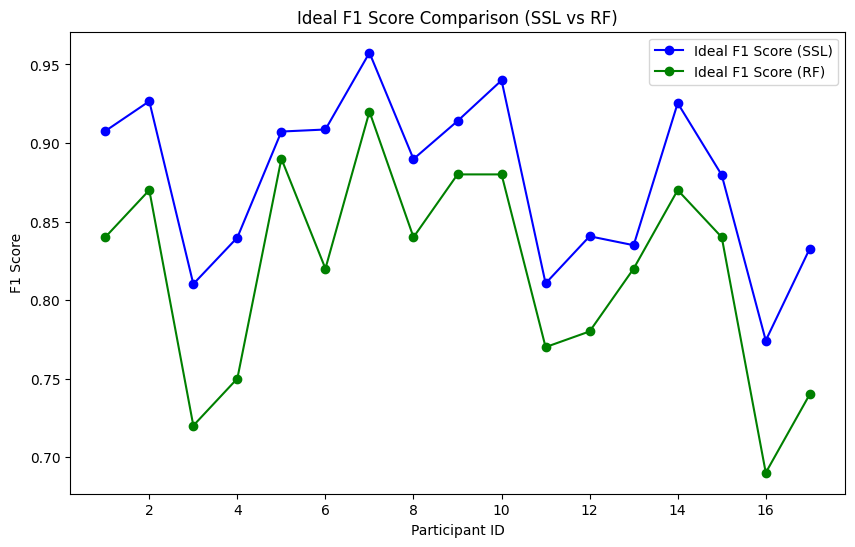

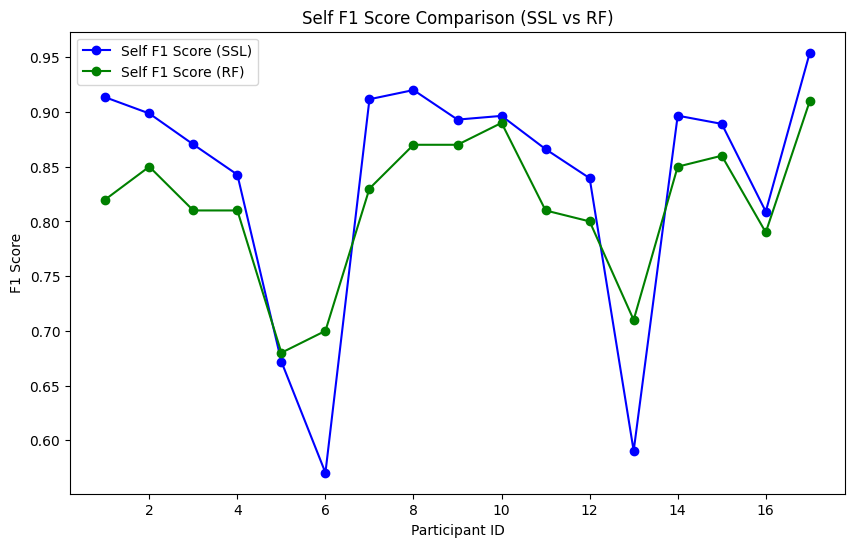

Average Ideal F1 Score (SSL): 0.8764
Average Ideal F1 Score (RF): 0.8188
Average Self F1 Score (SSL): 0.8372
Average Self F1 Score (RF): 0.8153
Drop in F1 Score from Ideal to Self (SSL): 0.0392 (4.47% depreciation)
Drop in F1 Score from Ideal to Self (RF): 0.0035 (0.43% depreciation)
Average F1 Score Difference (SSL - RF) for Ideal: 0.0576 (6.57% depreciation)
Average F1 Score Difference (SSL - RF) for Self: 0.0219 (2.62% depreciation)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
data = pd.read_csv("REALDISP_VALUES_RF.csv")

# Display the data to confirm loading
print(data)

# Plot F1 Scores for Ideal (SSL vs RF) for each participant
plt.figure(figsize=(10, 6))
plt.plot(data['Participant_id'], data['Ideal_F1(SSL)'], label='Ideal F1 Score (SSL)', marker='o', color='b')
plt.plot(data['Participant_id'], data['Ideal_F1(RF)'], label='Ideal F1 Score (RF)', marker='o', color='g')
plt.xlabel('Participant ID')
plt.ylabel('F1 Score')
plt.title('Ideal F1 Score Comparison (SSL vs RF)')
plt.legend()
plt.show()

# Plot F1 Scores for Self (SSL vs RF) for each participant
plt.figure(figsize=(10, 6))
plt.plot(data['Participant_id'], data['Self_F1(SSL)'], label='Self F1 Score (SSL)', marker='o', color='b')
plt.plot(data['Participant_id'], data['Self_F1(RF)'], label='Self F1 Score (RF)', marker='o', color='g')
plt.xlabel('Participant ID')
plt.ylabel('F1 Score')
plt.title('Self F1 Score Comparison (SSL vs RF)')
plt.legend()
plt.show()

# Calculate average F1 scores for both models and both placements
average_ideal_ssl = data['Ideal_F1(SSL)'].mean()
average_ideal_rf = data['Ideal_F1(RF)'].mean()
average_self_ssl = data['Self_F1(SSL)'].mean()
average_self_rf = data['Self_F1(RF)'].mean()

print(f"Average Ideal F1 Score (SSL): {average_ideal_ssl:.4f}")
print(f"Average Ideal F1 Score (RF): {average_ideal_rf:.4f}")
print(f"Average Self F1 Score (SSL): {average_self_ssl:.4f}")
print(f"Average Self F1 Score (RF): {average_self_rf:.4f}")

# Calculate the drop and depreciation in F1 score from Ideal to Self for both models
drop_ideal_self_ssl = average_ideal_ssl - average_self_ssl
depreciation_ideal_self_ssl = (drop_ideal_self_ssl / average_ideal_ssl) * 100

drop_ideal_self_rf = average_ideal_rf - average_self_rf
depreciation_ideal_self_rf = (drop_ideal_self_rf / average_ideal_rf) * 100

print(f"Drop in F1 Score from Ideal to Self (SSL): {drop_ideal_self_ssl:.4f} ({depreciation_ideal_self_ssl:.2f}% depreciation)")
print(f"Drop in F1 Score from Ideal to Self (RF): {drop_ideal_self_rf:.4f} ({depreciation_ideal_self_rf:.2f}% depreciation)")

# Calculate the average difference and depreciation between SSL and RF for Ideal and Self
average_difference_ideal = average_ideal_ssl - average_ideal_rf
depreciation_difference_ideal = (average_difference_ideal / average_ideal_ssl) * 100

average_difference_self = average_self_ssl - average_self_rf
depreciation_difference_self = (average_difference_self / average_self_ssl) * 100

print(f"Average F1 Score Difference (SSL - RF) for Ideal: {average_difference_ideal:.4f} ({depreciation_difference_ideal:.2f}% depreciation)")
print(f"Average F1 Score Difference (SSL - RF) for Self: {average_difference_self:.4f} ({depreciation_difference_self:.2f}% depreciation)")


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis

# Define columns of interest
LLA_ACC_X = 55
LLA_ACC_Y = 56
LLA_ACC_Z = 57
ACTIVITY_LABEL = -1  # Last column is activity label

def resample_data(data, labels, original_freq=50, target_freq=30):
    """
    Resample the data from the original frequency to the target frequency.

    Args:
        data (ndarray): Sensor data with shape (n_samples, n_features).
        labels (ndarray): Corresponding labels with shape (n_samples,).
        original_freq (int): Original sampling frequency of the data.
        target_freq (int): Target sampling frequency.

    Returns:
        resampled_data (ndarray): Resampled sensor data.
        resampled_labels (ndarray): Resampled labels.
    """
    factor = original_freq / target_freq
    if not factor.is_integer():
        raise ValueError("Original frequency must be a multiple of the target frequency.")

    factor = int(factor)
    resampled_data = data[::factor]
    resampled_labels = labels[::factor]
    return resampled_data, resampled_labels


# Functions for loading, windowing, and feature extraction
def load_realdisp_data(file_path, sensor_columns):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    lla_data = df.iloc[:, sensor_columns].values
    labels = df.iloc[:, ACTIVITY_LABEL].values
    return lla_data, labels

def create_windows(X, y, window_size=300, overlap=0.5):
    step = int(window_size * (1 - overlap))
    features, labels = [], []
    for i in range(0, len(X) - window_size, step):
        window = X[i:i + window_size].T
        if window.shape == (3, window_size):  # Ensure proper window shape
            label = y[i + window_size // 2]
            features.append(window)
            labels.append(label)
    return np.array(features), np.array(labels)

def extract_features(window):
    features = []
    for axis in range(window.shape[0]):
        axis_data = window[axis, :]
        features.extend([
            np.max(axis_data), np.min(axis_data), np.sum(axis_data),
            np.mean(axis_data), np.median(axis_data), np.std(axis_data),
            np.abs(axis_data).mean(), skew(axis_data), kurtosis(axis_data)
        ])
    return np.array(features)

def prepare_feature_data(X_windows):
    return np.array([extract_features(window) for window in X_windows])

def train_and_evaluate_randomforest_self(participant_id, dataset_path, anomaly_files=[], window_size=300, overlap=0.5):
    """
    Train RandomForest on self-placement data excluding anomalies and test on the self-placement data of the left-out participant.
    Includes window analysis visualization.
    """
    # Load training and testing files, excluding anomalies
    self_files = [
        f for f in os.listdir(dataset_path)
        if '_self.log' in f and f.split('_')[0] != f"subject{participant_id}" and f not in anomaly_files
    ]
    self_test_files = [
        f for f in os.listdir(dataset_path)
        if '_self.log' in f and f.split('_')[0] == f"subject{participant_id}" and f not in anomaly_files
    ]

    print(f"Training Files (Self): {self_files}")
    print(f"Testing Files (Self): {self_test_files}")

    # Check if lists are empty
    if not self_files:
        raise ValueError("No valid training files found after excluding anomalies.")
    if not self_test_files:
        raise ValueError(f"No valid testing files found for Participant {participant_id} after excluding anomalies.")

    # Load and process training data
    X_train, y_train = [], []
    for file in self_files:
        lla_data, labels = load_realdisp_data(os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z])
        X_windows, y_windows = create_windows(lla_data, labels, window_size, overlap)
        X_train.extend(X_windows)
        y_train.extend(y_windows)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Load and process testing data
    X_test, y_test = [], []
    for file in self_test_files:
        lla_data, labels = load_realdisp_data(os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z])
        X_windows, y_windows = create_windows(lla_data, labels, window_size, overlap)
        X_test.extend(X_windows)
        y_test.extend(y_windows)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Debug: Check shapes
    print(f"Training Data Shape: {X_train.shape}, Labels: {y_train.shape}")
    print(f"Testing Data Shape: {X_test.shape}, Labels: {y_test.shape}")

    # Visualize the number of windows for training and testing
    plt.figure(figsize=(12, 6))
    plt.bar(['Training Windows', 'Testing Windows'], [len(X_train), len(X_test)], color=['blue', 'orange'])
    plt.xlabel('Dataset Type')
    plt.ylabel('Number of Windows')
    plt.title(f'Window Analysis for Participant {participant_id}')
    plt.tight_layout()
    plt.show()

    # Extract features
    X_train_features = prepare_feature_data(X_train)
    X_test_features = prepare_feature_data(X_test)

    # Visualize the feature matrix shape
    print(f"Training Features Shape: {X_train_features.shape}, Testing Features Shape: {X_test_features.shape}")

    # Train RandomForest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_features, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test_features)
    test_accuracy = (y_pred == y_test).sum() / len(y_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Participant {participant_id} Test Accuracy: {test_accuracy:.4f}")
    print(f"Participant {participant_id} Test F1 Score: {test_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visualize accuracy and F1 score
    plt.figure(figsize=(8, 5))
    plt.bar(['Test Accuracy', 'Test F1 Score'], [test_accuracy, test_f1], color=['green', 'purple'])
    plt.ylim(0, 1)
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title(f'Performance Metrics for Participant {participant_id}')
    plt.tight_layout()
    plt.show()

    return rf_model, test_accuracy, test_f1


In [ ]:
# Example usage
anomaly_files = [
    "subject5_ideal.log", "subject5_self.log",
    "subject6_ideal.log", "subject6_self.log",
    "subject13_ideal.log", "subject13_self.log"
]
dataset_path = './dataset'




In [ ]:
#@title Participant left out= 17 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='17', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject17_self.log']


<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc

Training Data Shape: (15343, 3, 300), Labels: (15343,)
Testing Data Shape: (1048, 3, 300), Labels: (1048,)
Participant 17 Test Accuracy: 0.9027
Participant 17 Test F1 Score: 0.8757

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       878
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7
           7       0.80      0.57      0.67         7
           8       1.00      0.75      0.86         4
           9       0.00      0.00      0.00        13
          10       1.00      1.00      1.00        11
          11       0.00      0.00      0.00        12
          12       1.00      0.57      0.73         7
          13       1.00      0.82      0.90        11
          14       1.00      0.56     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject16_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15287, 3, 300), Labels: (15287,)
Testing Data Shape: (1104, 3, 300), Labels: (1104,)


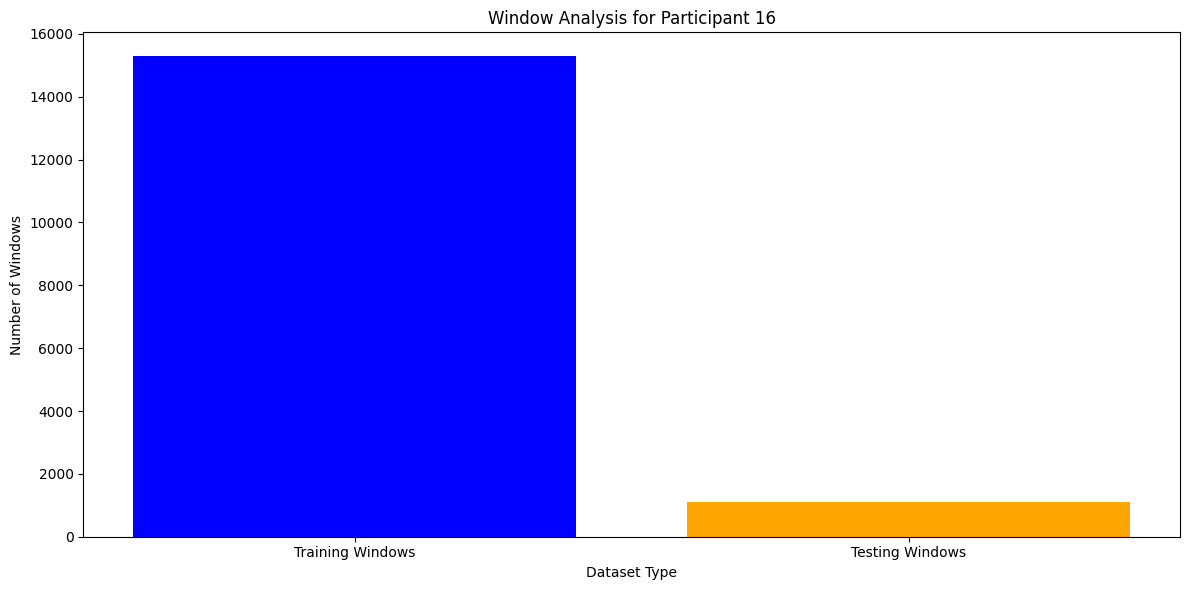

Training Features Shape: (15287, 27), Testing Features Shape: (1104, 27)
Participant 16 Test Accuracy: 0.7962
Participant 16 Test F1 Score: 0.7322

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       765
           1       0.00      0.00      0.00        23
           2       0.58      0.96      0.72        23
           3       0.88      0.61      0.72        23
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         4
           9       0.20      0.07      0.10        15
          10       1.00      1.00      1.00        11
          11       1.00      0.31      0.47        13
          12       0.86      0.86      0.86         7
          13       1.00      0.85      0.92        13
          14      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


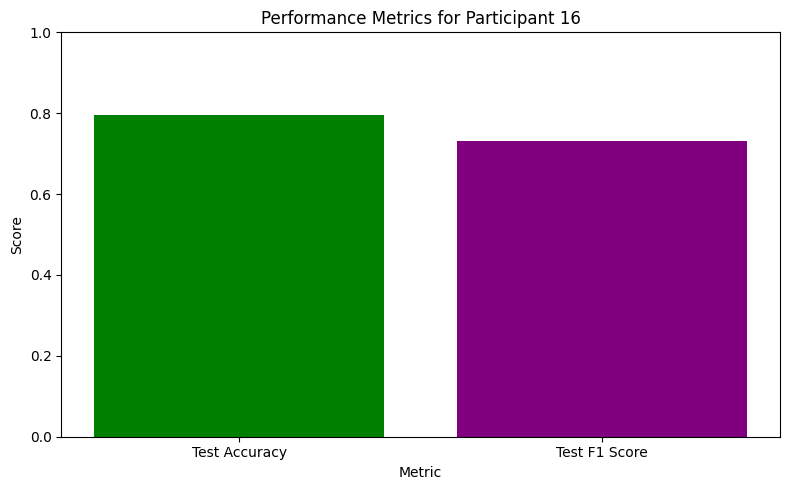

In [ ]:
#@title Participant left out= 16 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='16', dataset_path=dataset_path, anomaly_files=anomaly_files)


In [ ]:
#@title Participant left out= 15 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='15', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject15_self.log']


<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc

Training Data Shape: (15204, 3, 300), Labels: (15204,)
Testing Data Shape: (1187, 3, 300), Labels: (1187,)
Participant 15 Test Accuracy: 0.8357
Participant 15 Test F1 Score: 0.7927

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       899
           1       0.00      0.00      0.00        22
           2       1.00      0.41      0.58        17
           3       0.53      0.64      0.58        14
           4       0.00      0.00      0.00         4
           5       0.20      0.14      0.17         7
           6       0.00      0.00      0.00         7
           7       1.00      0.88      0.93         8
           8       1.00      0.75      0.86         4
           9       0.81      1.00      0.89        17
          10       0.61      1.00      0.76        11
          11       0.75      0.23      0.35        13
          12       1.00      0.30      0.46        10
          13       0.88      0.58     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
#@title Participant left out= 14 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='14', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject9_self.log']
Testing Files (Self): ['subject14_self.log']


<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc27d0e7>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-16-5f68cc

Training Data Shape: (15194, 3, 300), Labels: (15194,)
Testing Data Shape: (1197, 3, 300), Labels: (1197,)
Participant 14 Test Accuracy: 0.8312
Participant 14 Test F1 Score: 0.7751

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       909
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        17
           3       0.47      1.00      0.64        15
           4       0.00      0.00      0.00         4
           5       1.00      0.14      0.25         7
           6       0.00      0.00      0.00         7
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         4
           9       0.75      0.35      0.48        17
          10       1.00      1.00      1.00        12
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         9
          13       1.00      0.08     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject12_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15421, 3, 300), Labels: (15421,)
Testing Data Shape: (970, 3, 300), Labels: (970,)


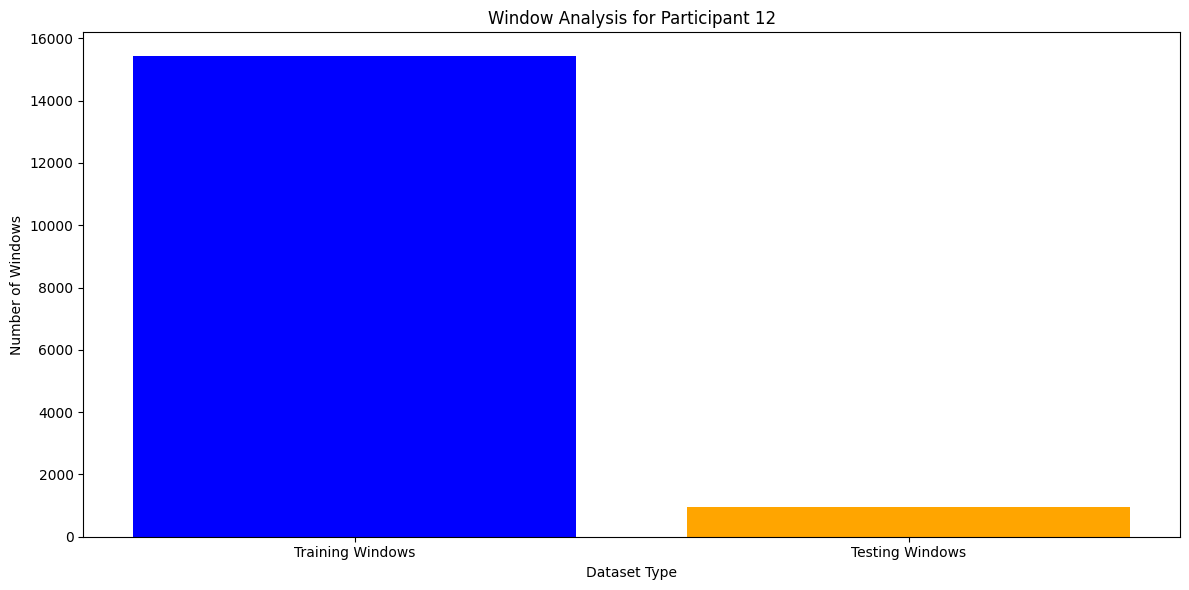

Training Features Shape: (15421, 27), Testing Features Shape: (970, 27)
Participant 12 Test Accuracy: 0.8062
Participant 12 Test F1 Score: 0.7472

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       699
           1       0.00      0.00      0.00        20
           2       0.92      0.61      0.73        18
           3       0.72      0.76      0.74        17
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.56      0.71      0.62         7
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00        15
          10       1.00      0.93      0.96        14
          11       0.41      0.64      0.50        14
          12       0.50      0.22      0.31         9
          13       0.00      0.00      0.00        12
          14       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


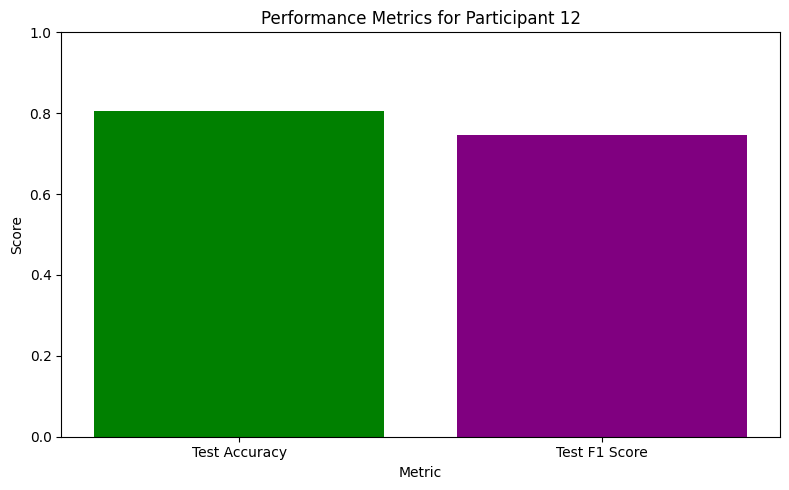

In [ ]:
#@title Participant left out= 12 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='12', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject11_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15345, 3, 300), Labels: (15345,)
Testing Data Shape: (1046, 3, 300), Labels: (1046,)


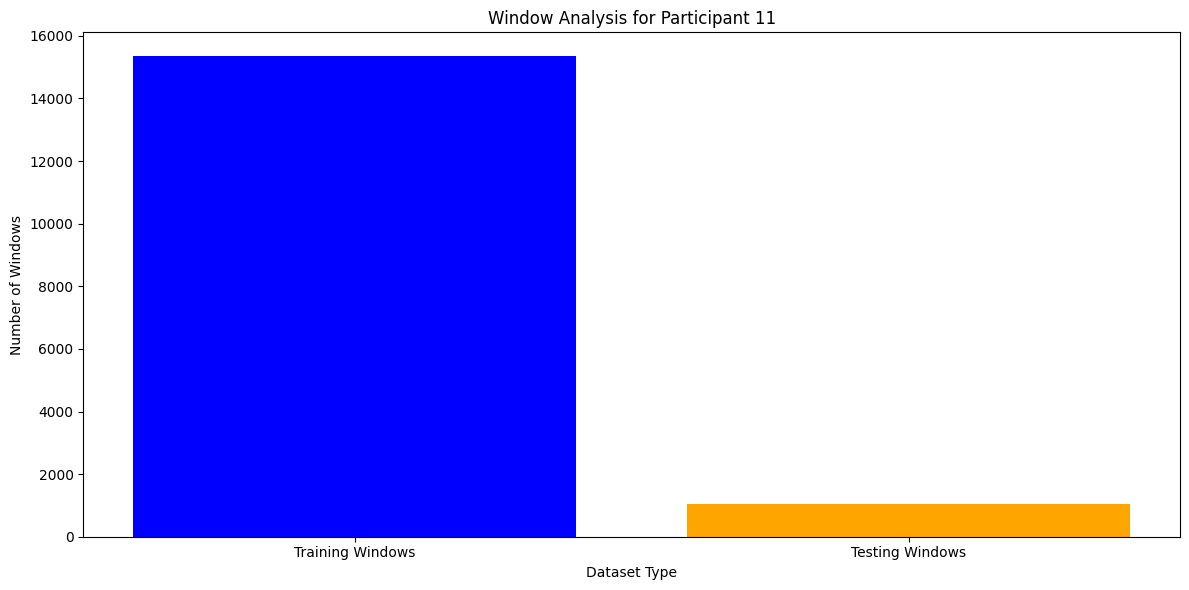

Training Features Shape: (15345, 27), Testing Features Shape: (1046, 27)
Participant 11 Test Accuracy: 0.8136
Participant 11 Test F1 Score: 0.7544

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       759
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        19
           3       0.91      0.59      0.71        17
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         7
           7       1.00      1.00      1.00         7
           8       0.00      0.00      0.00         4
           9       0.55      0.80      0.65        15
          10       1.00      0.64      0.78        14
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         8
          13       1.00      0.54      0.70        13
          14      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


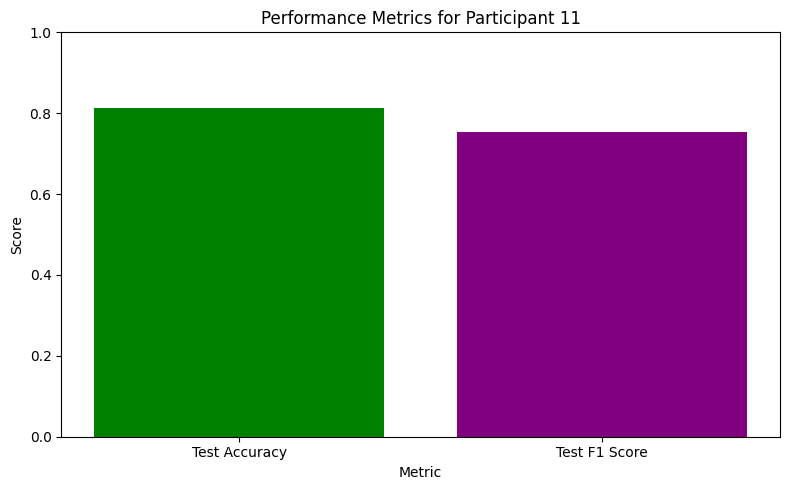

In [ ]:
#@title Participant left out= 11 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='11', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject10_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (14983, 3, 300), Labels: (14983,)
Testing Data Shape: (1408, 3, 300), Labels: (1408,)


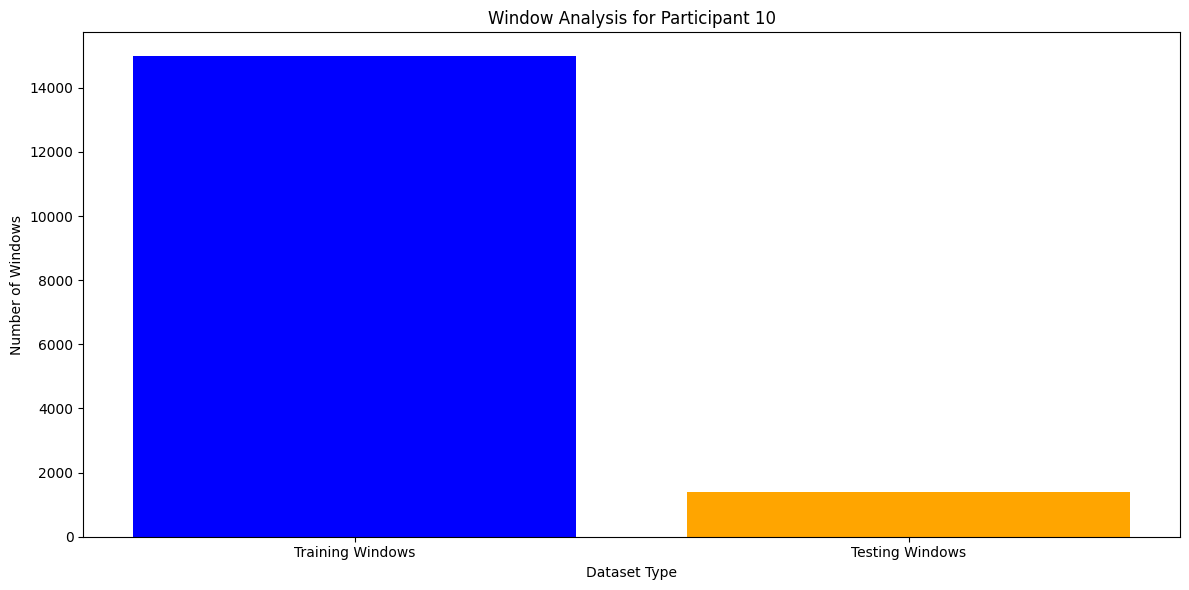

Training Features Shape: (14983, 27), Testing Features Shape: (1408, 27)
Participant 10 Test Accuracy: 0.8786
Participant 10 Test F1 Score: 0.8496

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1096
           1       0.25      0.10      0.14        21
           2       0.46      0.94      0.62        18
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7
           7       0.35      1.00      0.52         6
           8       1.00      1.00      1.00         5
           9       1.00      0.73      0.84        11
          10       1.00      0.89      0.94         9
          11       0.00      0.00      0.00        11
          12       1.00      0.67      0.80         9
          13       1.00      0.70      0.82        10
          14      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


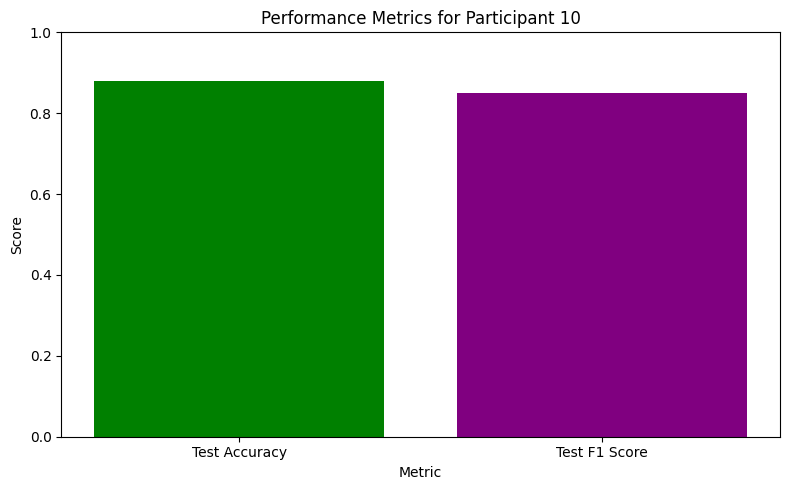

In [ ]:
#@title Participant left out= 10 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='10', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log']
Testing Files (Self): ['subject9_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15048, 3, 300), Labels: (15048,)
Testing Data Shape: (1343, 3, 300), Labels: (1343,)


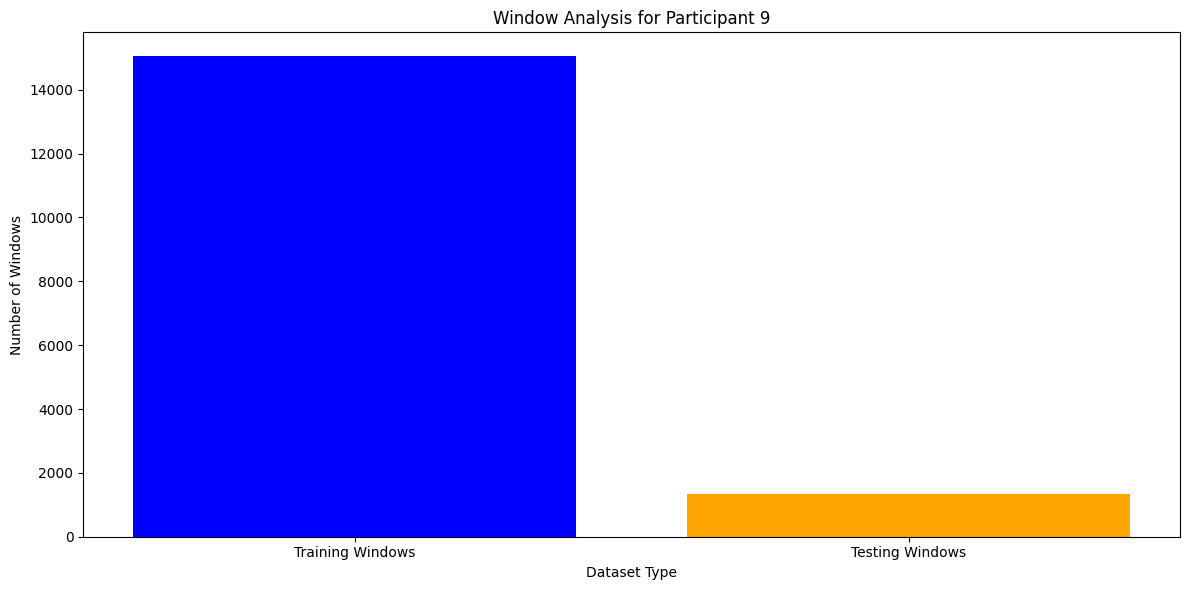

Training Features Shape: (15048, 27), Testing Features Shape: (1343, 27)
Participant 9 Test Accuracy: 0.8645
Participant 9 Test F1 Score: 0.8268

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1029
           1       0.00      0.00      0.00        21
           2       0.42      0.94      0.58        16
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         7
           7       1.00      0.86      0.92         7
           8       0.83      1.00      0.91         5
           9       1.00      0.82      0.90        11
          10       1.00      1.00      1.00         9
          11       1.00      0.55      0.71        11
          12       1.00      0.33      0.50         9
          13       1.00      0.90      0.95        10
          14       1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


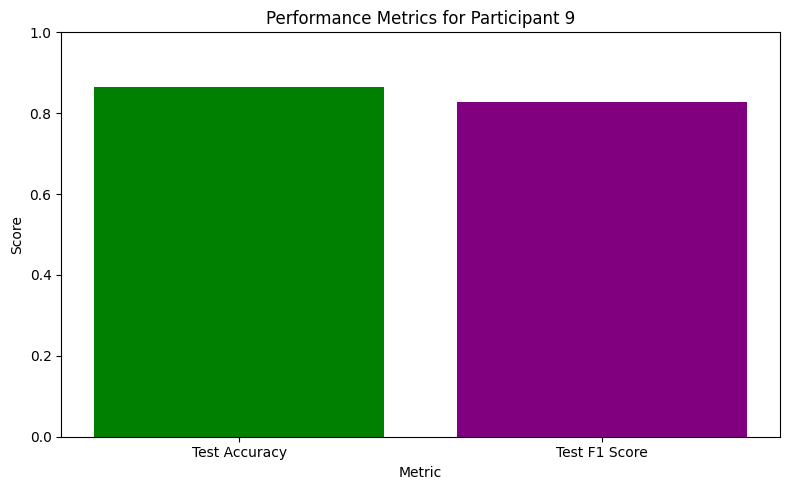

In [ ]:
#@title Participant left out= 9 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='9', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject8_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15032, 3, 300), Labels: (15032,)
Testing Data Shape: (1359, 3, 300), Labels: (1359,)


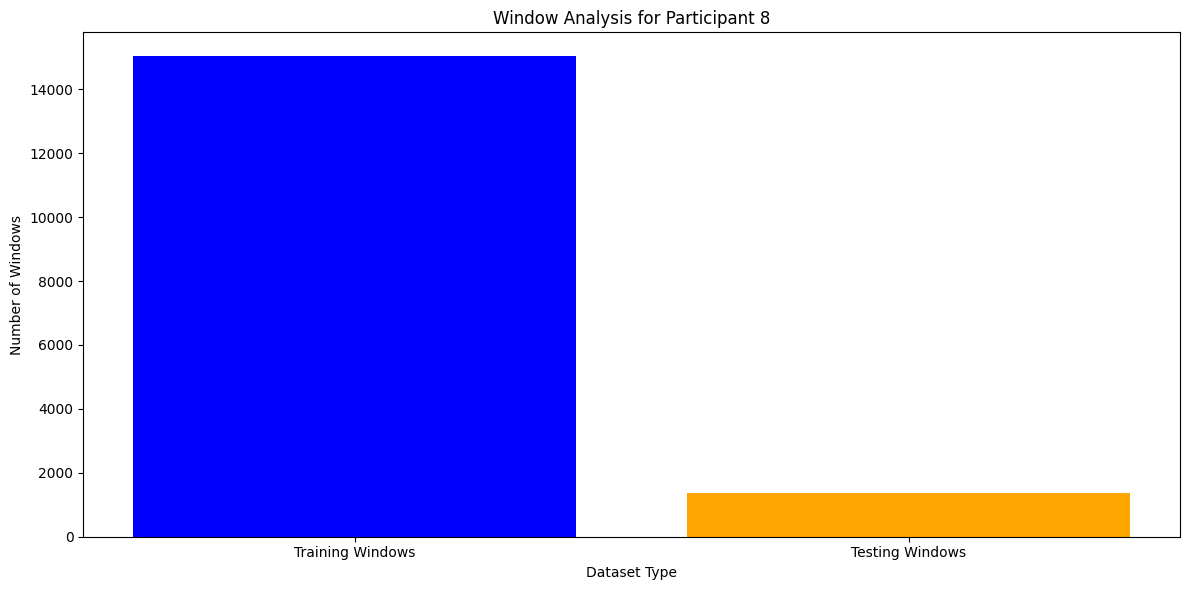

Training Features Shape: (15032, 27), Testing Features Shape: (1359, 27)
Participant 8 Test Accuracy: 0.8639
Participant 8 Test F1 Score: 0.8329

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1077
           1       1.00      0.36      0.53        11
           2       1.00      0.17      0.29        12
           3       0.50      0.94      0.65        17
           4       0.00      0.00      0.00         4
           5       0.11      0.14      0.12         7
           6       0.00      0.00      0.00         6
           7       1.00      1.00      1.00         8
           8       0.80      1.00      0.89         4
           9       1.00      0.20      0.33        10
          10       1.00      1.00      1.00         9
          11       0.25      0.09      0.13        11
          12       1.00      0.83      0.91        12
          13       1.00      0.50      0.67        10
          14       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


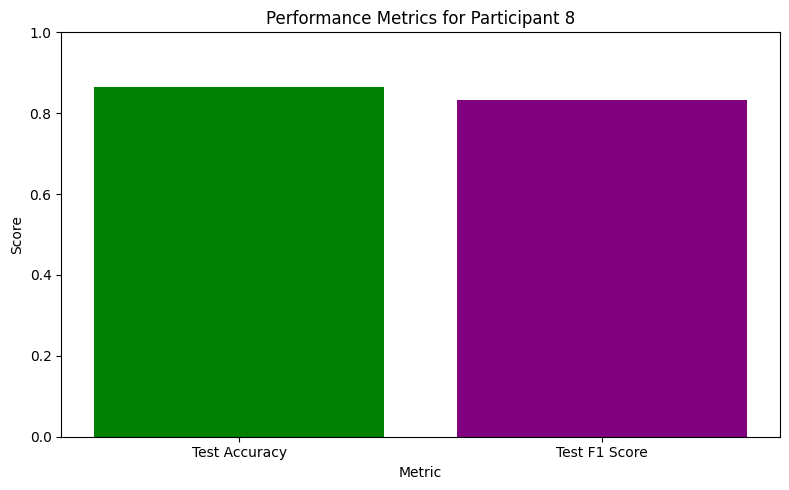

In [ ]:
#@title Participant left out= 8 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='8', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject7_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15308, 3, 300), Labels: (15308,)
Testing Data Shape: (1083, 3, 300), Labels: (1083,)


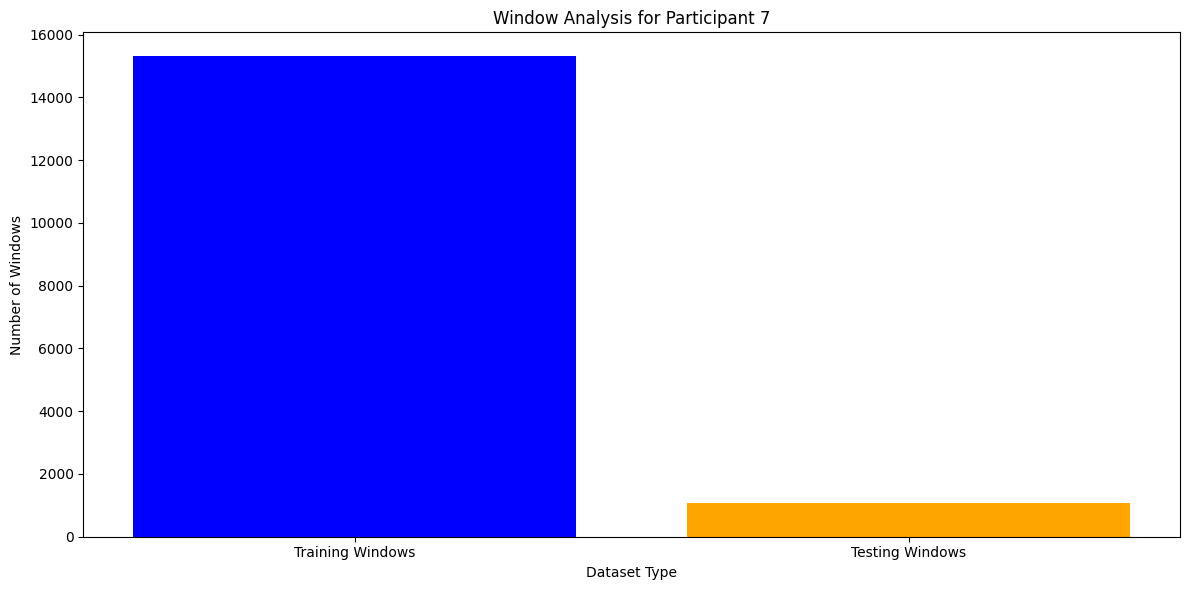

Training Features Shape: (15308, 27), Testing Features Shape: (1083, 27)
Participant 7 Test Accuracy: 0.8329
Participant 7 Test F1 Score: 0.7869

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       802
           1       0.50      0.27      0.35        11
           2       0.33      0.15      0.21        13
           3       0.43      0.71      0.53        17
           4       0.00      0.00      0.00         3
           5       0.67      0.33      0.44         6
           6       0.00      0.00      0.00         7
           7       0.80      1.00      0.89         8
           8       1.00      0.80      0.89         5
           9       1.00      0.80      0.89        10
          10       1.00      0.89      0.94         9
          11       0.75      0.60      0.67        10
          12       1.00      1.00      1.00        11
          13       1.00      0.67      0.80         9
          14       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


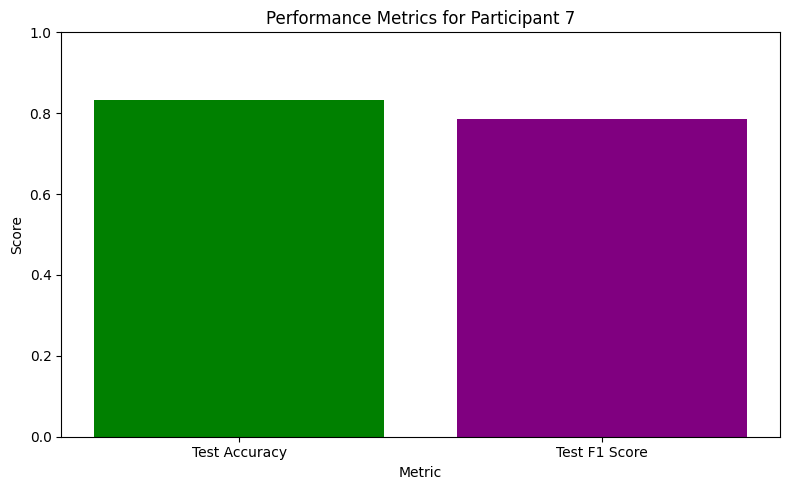

In [ ]:
#@title Participant left out= 7 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='7', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject4_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15058, 3, 300), Labels: (15058,)
Testing Data Shape: (1333, 3, 300), Labels: (1333,)


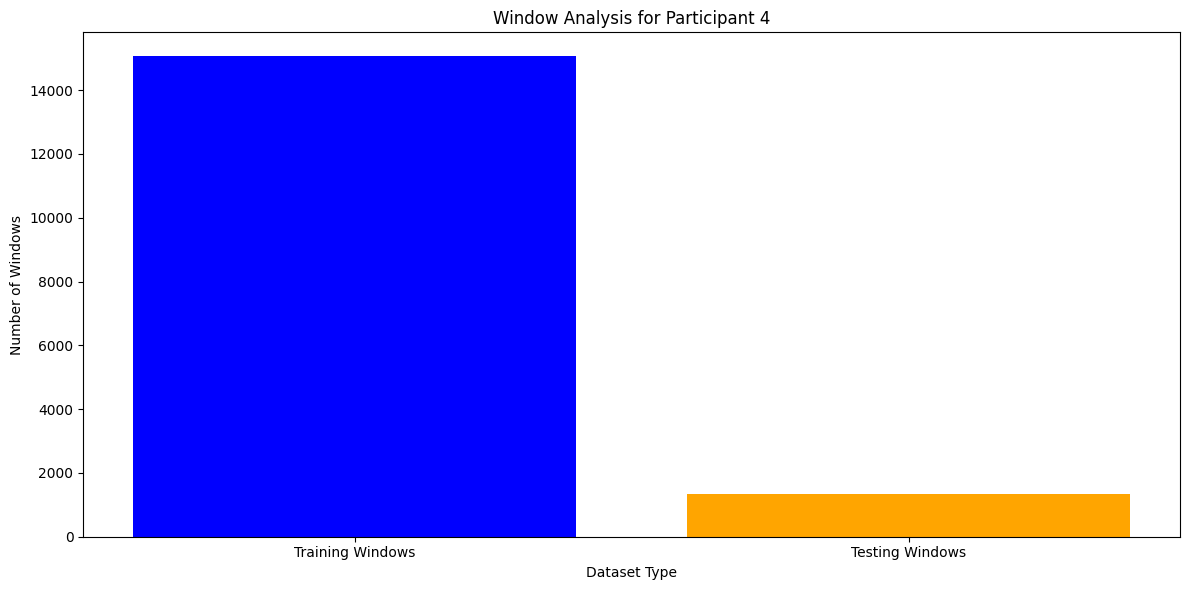

Training Features Shape: (15058, 27), Testing Features Shape: (1333, 27)
Participant 4 Test Accuracy: 0.8117
Participant 4 Test F1 Score: 0.7574

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1031
           1       0.00      0.00      0.00        16
           2       1.00      0.36      0.53        14
           3       0.48      1.00      0.65        14
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         8
           8       0.43      0.75      0.55         4
           9       0.00      0.00      0.00        15
          10       1.00      1.00      1.00        11
          11       0.00      0.00      0.00        11
          12       1.00      0.80      0.89        10
          13       0.00      0.00      0.00        10
          14       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


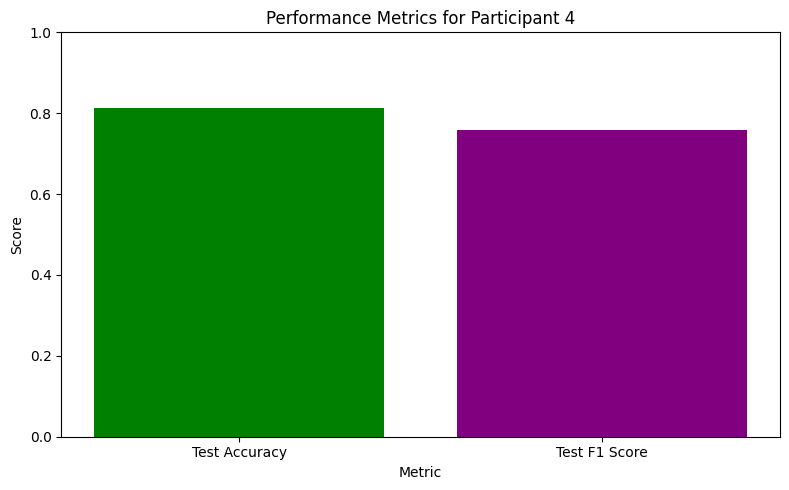

In [ ]:
#@title Participant left out= 4 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='4', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject3_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15285, 3, 300), Labels: (15285,)
Testing Data Shape: (1106, 3, 300), Labels: (1106,)


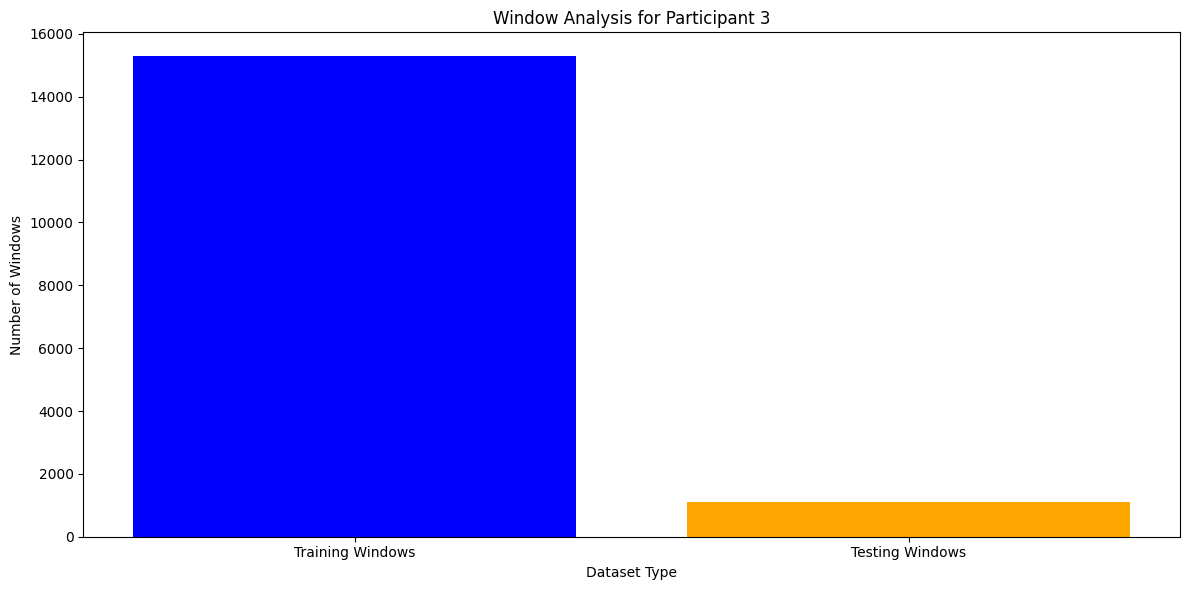

Training Features Shape: (15285, 27), Testing Features Shape: (1106, 27)
Participant 3 Test Accuracy: 0.8038
Participant 3 Test F1 Score: 0.7425

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       799
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.43      0.86      0.57         7
           8       0.00      0.00      0.00         3
           9       0.79      0.61      0.69        18
          10       0.83      0.91      0.87        11
          11       0.67      0.83      0.74        12
          12       1.00      0.80      0.89        10
          13       0.50      1.00      0.67        10
          14       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


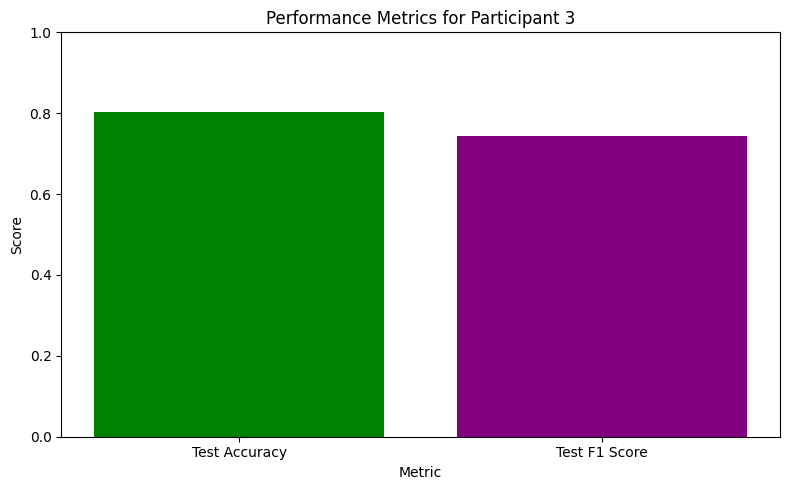

In [ ]:
#@title Participant left out= 3 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='3', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject2_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15291, 3, 300), Labels: (15291,)
Testing Data Shape: (1100, 3, 300), Labels: (1100,)


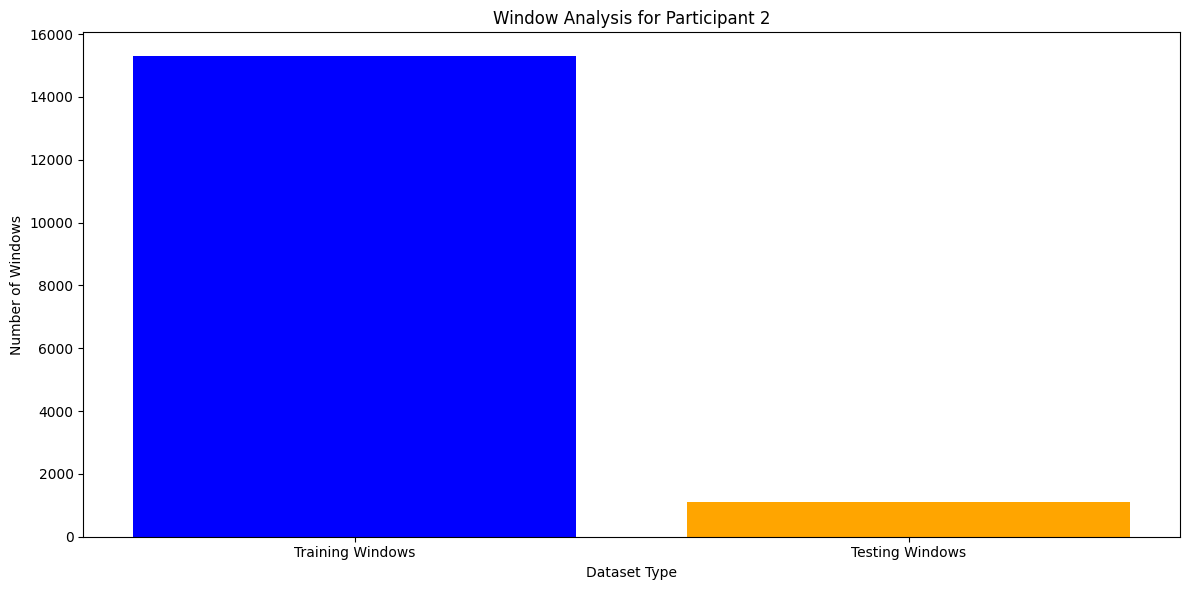

Training Features Shape: (15291, 27), Testing Features Shape: (1100, 27)
Participant 2 Test Accuracy: 0.8400
Participant 2 Test F1 Score: 0.7860

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       770
           1       0.00      0.00      0.00        18
           2       0.47      0.94      0.63        17
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7
           7       1.00      0.86      0.92         7
           8       1.00      1.00      1.00         4
           9       0.62      0.87      0.72        15
          10       0.73      0.73      0.73        11
          11       0.00      0.00      0.00        12
          12       0.55      0.92      0.69        12
          13       1.00      1.00      1.00        10
          14       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


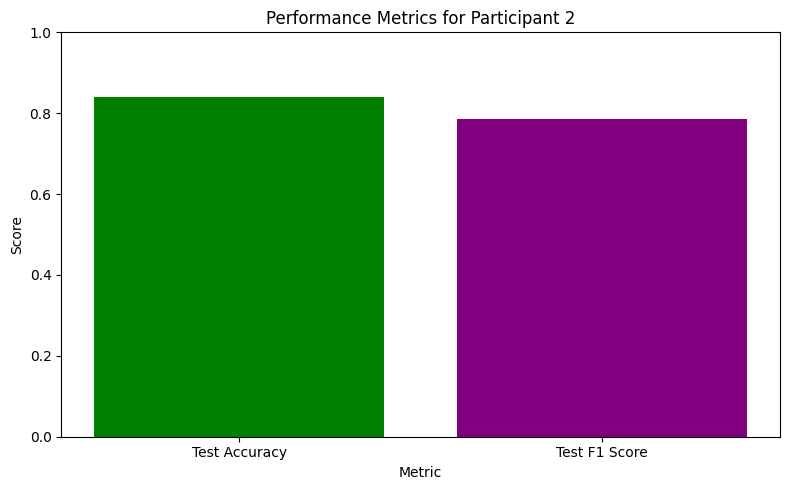

In [ ]:
#@title Participant left out= 2 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='2', dataset_path=dataset_path, anomaly_files=anomaly_files)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject1_self.log']


<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd481bf6d0>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-a9cd48

Training Data Shape: (15284, 3, 300), Labels: (15284,)
Testing Data Shape: (1107, 3, 300), Labels: (1107,)


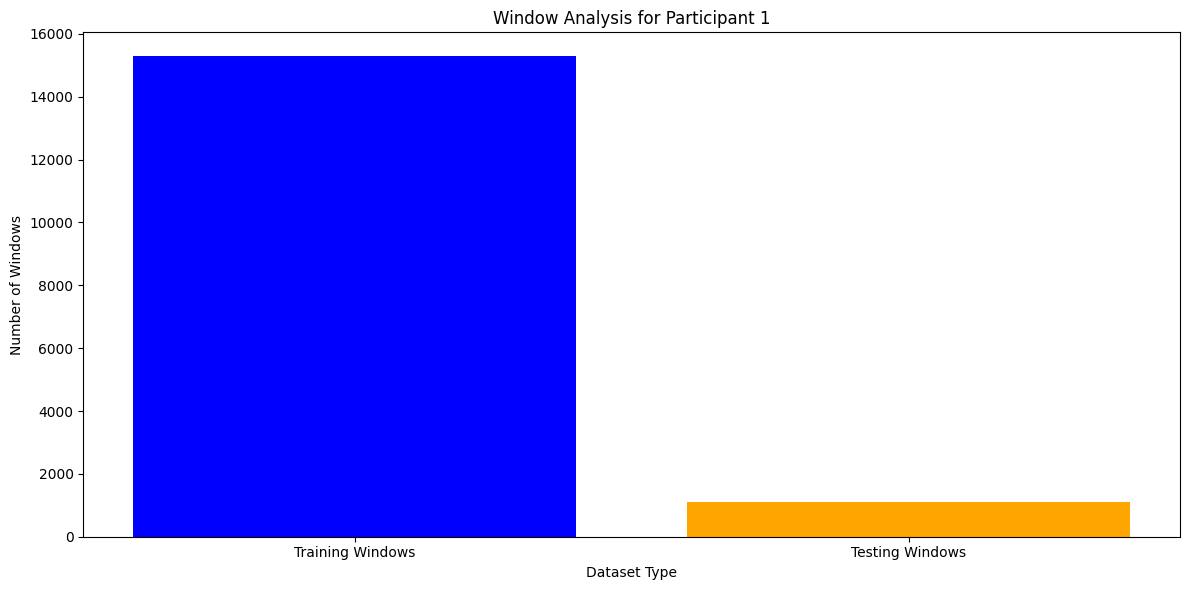

Training Features Shape: (15284, 27), Testing Features Shape: (1107, 27)
Participant 1 Test Accuracy: 0.7823
Participant 1 Test F1 Score: 0.7064

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       776
           1       0.00      0.00      0.00        18
           2       0.29      0.29      0.29        17
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         7
           8       0.38      1.00      0.56         5
           9       1.00      0.93      0.96        14
          10       1.00      1.00      1.00        11
          11       0.00      0.00      0.00        12
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        11
          14       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


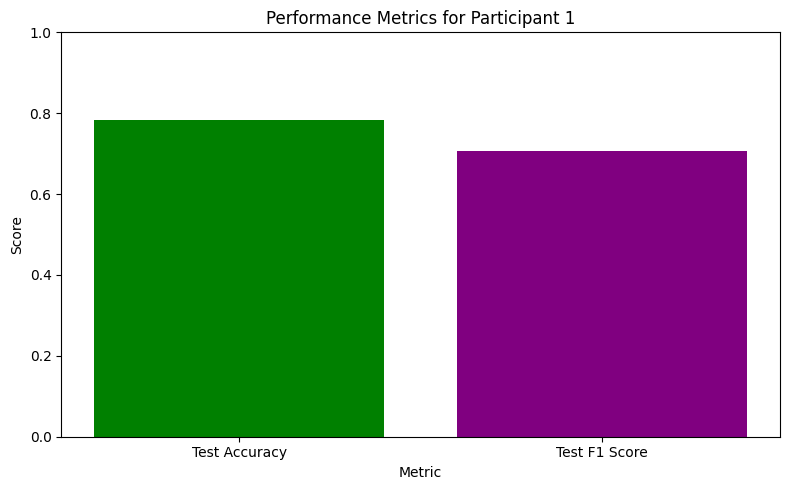

In [ ]:
#@title Participant left out= 1 (Self train)
dataset_path = './dataset'
rf_model, accuracy, f1 = train_and_evaluate_randomforest_self(participant_id='1', dataset_path=dataset_path, anomaly_files=anomaly_files)


    Participant_id  Ideal_Ideal_F1(SSL)  Ideal_Self_F1(SSL)  \
0                1               0.9076              0.9134   
1                2               0.9266              0.8986   
2                3               0.8102              0.8703   
3                4               0.8398              0.8427   
4                7               0.9575              0.9116   
5                8               0.8898              0.9200   
6                9               0.9140              0.8930   
7               10               0.9399              0.8964   
8               11               0.8106              0.8660   
9               12               0.8406              0.8395   
10              14               0.9254              0.8966   
11              15               0.8796              0.8891   
12              16               0.7742              0.8090   
13              17               0.8328              0.9541   

    Ideal_Ideal_F1(RF)  Ideal_Self_F1(RF)  Self_Self_F

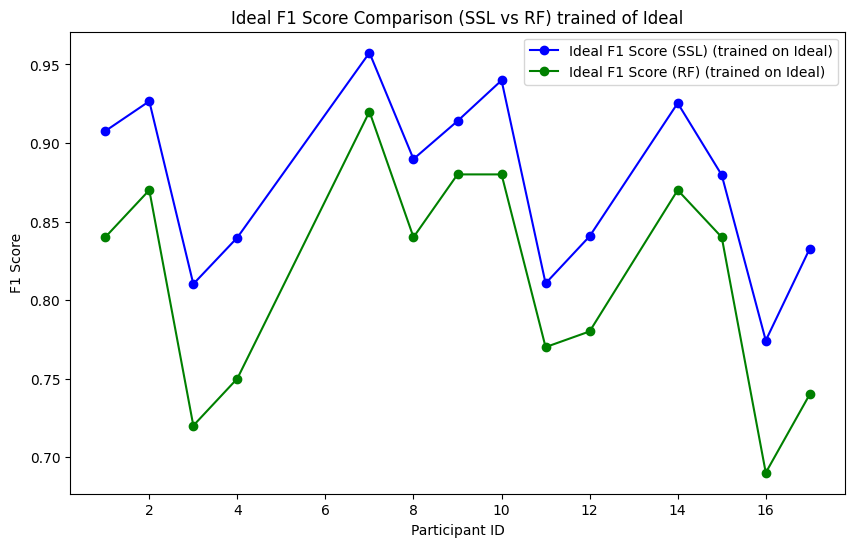

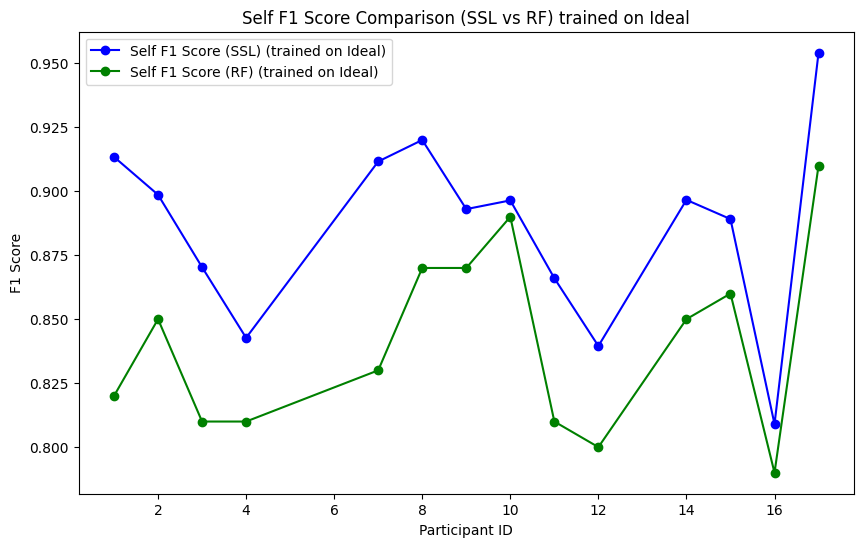

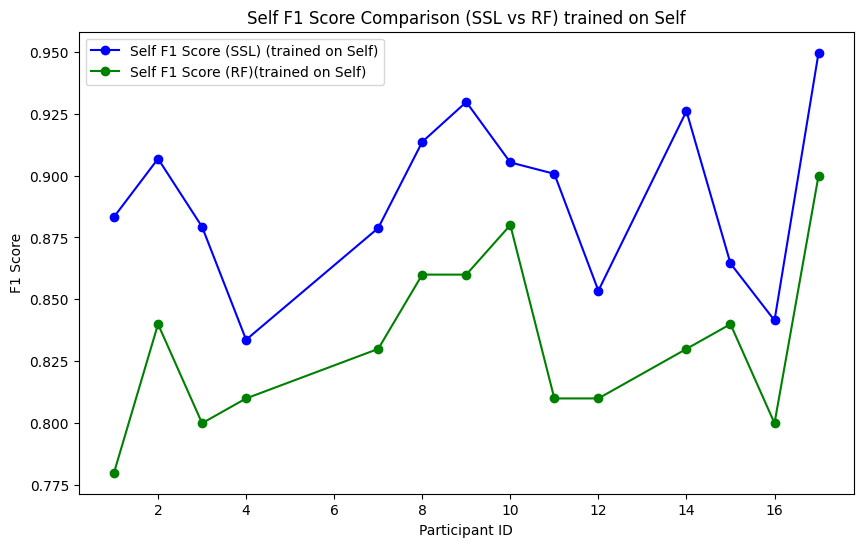

Average Ideal F1 Score (SSL) trained on ideal: 0.8749
Average Ideal F1 Score (RF) trained on ideal: 0.8136
Average Self F1 Score (SSL) trained on ideal: 0.8857
Average Self F1 Score (RF) trained on ideal: 0.8407
Average Self F1 Score (SSL) trained on self: 0.8905
Average Self F1 Score (RF) trained on self: 0.8321
Drop in F1 Score from Ideal to Self (SSL): -0.0108 (-1.24% depreciation)
Drop in F1 Score from Ideal to Self (RF): -0.0271 (-3.34% depreciation)
Average F1 Score Difference (SSL - RF) for Ideal: 0.0613 (7.01% depreciation)
Average F1 Score Difference (SSL - RF) for Self: 0.0450 (5.08% depreciation)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
data = pd.read_csv("Realdisp_final.csv")

# Display the data to confirm loading
print(data)

# Plot F1 Scores for Ideal (SSL vs RF) for each participant
plt.figure(figsize=(10, 6))
plt.plot(data['Participant_id'], data['Ideal_Ideal_F1(SSL)'], label='Ideal F1 Score (SSL) (trained on Ideal)', marker='o', color='b')
plt.plot(data['Participant_id'], data['Ideal_Ideal_F1(RF)'], label='Ideal F1 Score (RF) (trained on Ideal)', marker='o', color='g')
plt.xlabel('Participant ID')
plt.ylabel('F1 Score')
plt.title('Ideal F1 Score Comparison (SSL vs RF) trained of Ideal')
plt.legend()
plt.show()

# Plot F1 Scores for Self (SSL vs RF) for each participant
plt.figure(figsize=(10, 6))
plt.plot(data['Participant_id'], data['Ideal_Self_F1(SSL)'], label='Self F1 Score (SSL) (trained on Ideal)', marker='o', color='b')
plt.plot(data['Participant_id'], data['Ideal_Self_F1(RF)'], label='Self F1 Score (RF) (trained on Ideal)', marker='o', color='g')
plt.xlabel('Participant ID')
plt.ylabel('F1 Score')
plt.title('Self F1 Score Comparison (SSL vs RF) trained on Ideal')
plt.legend()
plt.show()

# Plot F1 Scores for Self (SSL vs RF) for each participant
plt.figure(figsize=(10, 6))
plt.plot(data['Participant_id'], data['Self_Self_F1(SSL)'], label='Self F1 Score (SSL) (trained on Self)', marker='o', color='b')
plt.plot(data['Participant_id'], data['Self_Self_F1(RF)'], label='Self F1 Score (RF)(trained on Self)', marker='o', color='g')
plt.xlabel('Participant ID')
plt.ylabel('F1 Score')
plt.title('Self F1 Score Comparison (SSL vs RF) trained on Self')
plt.legend()
plt.show()

# Calculate average F1 scores for both models and both placements
average_ideal_ssl = data['Ideal_Ideal_F1(SSL)'].mean()
average_ideal_rf = data['Ideal_Ideal_F1(RF)'].mean()
average_self_ssl = data['Ideal_Self_F1(SSL)'].mean()
average_self_rf = data['Ideal_Self_F1(RF)'].mean()
average_self_self_ssl = data['Self_Self_F1(SSL)'].mean()
average_self_self_rf = data['Self_Self_F1(RF)'].mean()

print(f"Average Ideal F1 Score (SSL) trained on ideal: {average_ideal_ssl:.4f}")
print(f"Average Ideal F1 Score (RF) trained on ideal: {average_ideal_rf:.4f}")
print(f"Average Self F1 Score (SSL) trained on ideal: {average_self_ssl:.4f}")
print(f"Average Self F1 Score (RF) trained on ideal: {average_self_rf:.4f}")
print(f"Average Self F1 Score (SSL) trained on self: {average_self_self_ssl:.4f}")
print(f"Average Self F1 Score (RF) trained on self: {average_self_self_rf:.4f}")

# Calculate the drop and depreciation in F1 score from Ideal to Self for both models
drop_ideal_self_ssl = average_ideal_ssl - average_self_ssl
depreciation_ideal_self_ssl = (drop_ideal_self_ssl / average_ideal_ssl) * 100

drop_ideal_self_rf = average_ideal_rf - average_self_rf
depreciation_ideal_self_rf = (drop_ideal_self_rf / average_ideal_rf) * 100

print(f"Drop in F1 Score from Ideal to Self (SSL): {drop_ideal_self_ssl:.4f} ({depreciation_ideal_self_ssl:.2f}% depreciation)")
print(f"Drop in F1 Score from Ideal to Self (RF): {drop_ideal_self_rf:.4f} ({depreciation_ideal_self_rf:.2f}% depreciation)")

# Calculate the average difference and depreciation between SSL and RF for Ideal and Self
average_difference_ideal = average_ideal_ssl - average_ideal_rf
depreciation_difference_ideal = (average_difference_ideal / average_ideal_ssl) * 100

average_difference_self = average_self_ssl - average_self_rf
depreciation_difference_self = (average_difference_self / average_self_ssl) * 100

print(f"Average F1 Score Difference (SSL - RF) for Ideal: {average_difference_ideal:.4f} ({depreciation_difference_ideal:.2f}% depreciation)")
print(f"Average F1 Score Difference (SSL - RF) for Self: {average_difference_self:.4f} ({depreciation_difference_self:.2f}% depreciation)")
